# Step 1: Get Data from AWS
To do this, we use a custom script:

In [288]:
# import stuff
from datetime import datetime
from tools.aws_goes import GOESArchiveDownloader, GOESProduct, save_s3_product
import xarray as xr
import metpy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# jupyter notebook config
%matplotlib inline

In [8]:
# setup params
startdate = datetime(2017, 9, 28, 23, 59, 0)
enddate = datetime(2017, 10, 6, 23, 59, 0)
outpath = "/Users/rmcmahon/dev/cyclone_classifier/data/aws_download"
arc = GOESArchiveDownloader()
ABI_prods = arc.get_range(startdate, enddate, GOESProduct(typ='ABI', channel=9, sector='full'))#, satellite = 'goes17'))

# download data
for s3obj in ABI_prods:
    save_s3_product(s3obj, outpath)

prod_mode is ABI-L1b-RadF-M3C09
ABI-L1b-RadF/2017/271/23/OR_ABI-L1b-RadF-M3C09_G16 ABI-L1b-RadF/2017/271/23/OR_ABI-L1b-RadF-M3C09_G16_s2017271235900
prod_mode is ABI-L1b-RadF-M3C09
ABI-L1b-RadF/2017/272/00/OR_ABI-L1b-RadF-M3C09_G16 ABI-L1b-RadF/2017/272/00/OR_ABI-L1b-RadF-M3C09_G16_s2017272000000
prod_mode is ABI-L1b-RadF-M3C09
ABI-L1b-RadF/2017/273/00/OR_ABI-L1b-RadF-M3C09_G16 ABI-L1b-RadF/2017/273/00/OR_ABI-L1b-RadF-M3C09_G16_s2017273000000
prod_mode is ABI-L1b-RadF-M3C09
ABI-L1b-RadF/2017/274/00/OR_ABI-L1b-RadF-M3C09_G16 ABI-L1b-RadF/2017/274/00/OR_ABI-L1b-RadF-M3C09_G16_s2017274000000
prod_mode is ABI-L1b-RadF-M3C09
ABI-L1b-RadF/2017/275/00/OR_ABI-L1b-RadF-M3C09_G16 ABI-L1b-RadF/2017/275/00/OR_ABI-L1b-RadF-M3C09_G16_s2017275000000
prod_mode is ABI-L1b-RadF-M3C09
ABI-L1b-RadF/2017/276/00/OR_ABI-L1b-RadF-M3C09_G16 ABI-L1b-RadF/2017/276/00/OR_ABI-L1b-RadF-M3C09_G16_s2017276000000
prod_mode is ABI-L1b-RadF-M3C09
ABI-L1b-RadF/2017/277/00/OR_ABI-L1b-RadF-M3C09_G16 ABI-L1b-RadF/2017/277/0

In [44]:
# Load in dummy data
fp = 'data/aws_download/OR_ABI-L1b-RadF-M3C09_G16_s20172790045389_e20172790056161_c20172790056226.nc'
ds = xr.open_dataset(fp)

<xarray.DataArray 't' ()>
array('2017-10-06T00:50:57.540230976', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2017-10-06T00:50:57.540230976
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time
    axis:           T
    bounds:         time_bounds

In [207]:
# load storm data
stormfp = 'data/storm/IBTrACS.since1980.v04r00.nc'  # all storm data since 1980 (much smaller dataset)
stormdata = xr.open_dataset(stormfp)

# figure out bounds between storms
first_storm_times = stormdata.isel(storm=[0]).time.values
last_storm_times = stormdata.isel(storm=[len(stormdata.storm)-1]).time.values
start_time = first_storm_times[~np.isnat(first_storm_times)].min()
end_time = last_storm_times[~np.isnat(last_storm_times)].max()

# generate date range
time_range = pd.date_range(start=start_time, end=end_time, freq='3H').values
time_range = time_range.astype('datetime64[s]')  # clip off the nanoseconds

# generate empty xarray object
dummydata = np.zeros((2, len(time_range), len(stormdata.storm.values)))
storm_id_time_data = xr.DataArray(dummydata,
                                  dims=['pos', 'time', 'storm_id'],
                                  coords=[['lat','lon'], time_range, stormdata.storm.values]
                                  )

In [304]:
stormdata

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 4484)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables: (12/147)
    numobs            (storm) float32 41.0 13.0 79.0 9.0 ... 41.0 9.0 93.0 31.0
    sid               (storm) |S13 b'1980001S13173' ... b'2021111S10049'
    season            (storm) float32 1.98e+03 1.98e+03 ... 2.021e+03 2.021e+03
    number            (storm) int16 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [303]:
stormdata.sel(storm=1)

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4)
Coordinates:
    time              (date_time) datetime64[ns] ...
    lat               (date_time) float32 ...
    lon               (date_time) float32 ...
Dimensions without coordinates: date_time, quadrant
Data variables: (12/147)
    numobs            float32 13.0
    sid               |S13 b'1980002S15081'
    season            float32 1.98e+03
    number            int16 2
    basin             (date_time) |S2 ...
    subbasin          (date_time) |S2 ...
    ...                ...
    reunion_gust      (date_time) float32 ...
    reunion_gust_per  (date_time) float32 ...
    usa_seahgt        (date_time) float32 ...
    usa_searad        (date_time, quadrant) float32 ...
    storm_speed       (date_time) float32 ...
    storm_dir         (date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [297]:
storm_id_time_data

<xarray.DataArray (pos: 2, time: 120718, storm_id: 4484)>
array([[[-12.5       ,   1.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [-12.19273663,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [-11.91436768,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
          22.46482277,  -7.84996271],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
          22.20000076,  -7.80000067],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
          21.91174316,  -7.78763819]],

       [[172.5       ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [172.44148254,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [172.41242981,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
         132.36997986,  40.22245026],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
         132.8999939 ,  39.70000076],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
         133.43281555,  39.15505219]]])
Coordinates:
  * pos       (pos) <U3 'lat' 'lon'
  * time      (time) datetime64[ns] 1980-01-01 ... 2021-04-24T15:00:00
  * storm_id  (storm_id) int64 0 1 2 3 4 5 6 ... 4478 4479 4480 4481 4482 4483

In [293]:
# pack storm object with data from storms
for storm_id in tqdm(stormdata.storm.values):
    storm = stormdata.isel(storm=storm_id)
    time_indices = storm.date_time.values
    for time_idx in time_indices:
        if not np.isnat(storm.date_time[time_idx].time.values):
            storm_at_time = storm.sel(date_time=storm.date_time[time_idx])
            time = storm_at_time.time.astype('datetime64[s]')  # convert to s as a lazy way to round
            try:
                storm_id_time_data.loc[dict(time=time, storm_id=storm_id, pos='lat')] = storm_at_time.lat
                storm_id_time_data.loc[dict(time=time, storm_id=storm_id, pos='lon')] = storm_at_time.lon
            except:
                print(time.values)

  0%|          | 12/4484 [00:09<1:03:33,  1.17it/s]

1980-02-03T00:01:00.000000000


  2%|▏         | 96/4484 [01:34<1:07:25,  1.08it/s]

1980-11-12T02:00:00.000000000
1980-11-12T14:00:00.000000000
1980-11-13T02:00:00.000000000
1980-11-13T14:00:00.000000000
1980-11-14T02:00:00.000000000
1980-11-14T14:00:00.000000000
1980-11-15T02:00:00.000000000
1980-11-15T14:00:00.000000000
1980-11-16T02:00:00.000000000
1980-11-16T14:00:00.000000000
1980-11-17T02:00:00.000000000
1980-11-17T14:00:00.000000000
1980-11-18T02:00:00.000000000
1980-11-18T14:00:00.000000000
1980-11-19T02:00:00.000000000
1980-11-19T08:00:00.000000000


  2%|▏         | 104/4484 [01:42<1:01:13,  1.19it/s]

1980-12-10T08:00:00.000000000
1980-12-10T14:00:00.000000000
1980-12-11T02:00:00.000000000
1980-12-11T14:00:00.000000000
1980-12-12T02:00:00.000000000
1980-12-12T14:00:00.000000000
1980-12-13T02:00:00.000000000
1980-12-13T14:00:00.000000000
1980-12-14T02:00:00.000000000
1980-12-14T14:00:00.000000000
1980-12-15T02:00:00.000000000
1980-12-15T14:00:00.000000000
1980-12-16T02:00:00.000000000
1980-12-16T14:00:00.000000000
1980-12-17T02:00:00.000000000
1980-12-17T14:00:00.000000000
1980-12-18T02:00:00.000000000
1980-12-18T14:00:00.000000000
1980-12-19T02:00:00.000000000
1980-12-19T14:00:00.000000000
1980-12-20T02:00:00.000000000


  2%|▏         | 109/4484 [01:47<1:07:45,  1.08it/s]

1980-12-17T04:00:00.000000000


  3%|▎         | 122/4484 [01:59<1:07:27,  1.08it/s]

1981-02-10T02:00:00.000000000
1981-02-10T13:00:00.000000000
1981-02-11T04:00:00.000000000


  3%|▎         | 127/4484 [02:04<1:17:23,  1.07s/it]

1981-03-05T14:00:00.000000000


  3%|▎         | 133/4484 [02:10<1:07:11,  1.08it/s]

1981-03-09T20:00:00.000000000
1981-03-09T23:00:00.000000000
1981-03-10T02:00:00.000000000
1981-03-10T05:00:00.000000000
1981-03-10T08:00:00.000000000
1981-03-10T11:00:00.000000000
1981-03-10T14:00:00.000000000
1981-03-10T17:00:00.000000000
1981-03-10T20:00:00.000000000
1981-03-10T23:00:00.000000000
1981-03-11T02:00:00.000000000
1981-03-11T05:00:00.000000000
1981-03-11T08:00:00.000000000
1981-03-11T11:00:00.000000000
1981-03-11T14:00:00.000000000
1981-03-11T17:00:00.000000000
1981-03-11T20:00:00.000000000
1981-03-11T23:00:00.000000000
1981-03-12T02:00:00.000000000
1981-03-12T05:00:00.000000000
1981-03-12T08:00:00.000000000
1981-03-12T11:00:00.000000000
1981-03-12T14:00:00.000000000
1981-03-12T17:00:00.000000000
1981-03-12T20:00:00.000000000
1981-03-12T23:00:00.000000000
1981-03-13T05:00:00.000000000
1981-03-13T08:00:00.000000000
1981-03-13T11:00:00.000000000
1981-03-13T14:00:00.000000000
1981-03-13T17:00:00.000000000
1981-03-15T01:00:00.000000000


  5%|▍         | 206/4484 [03:20<1:01:52,  1.15it/s]

1981-10-21T10:00:00.000000000
1981-10-21T16:00:00.000000000
1981-10-22T04:00:00.000000000
1981-10-22T16:00:00.000000000
1981-10-23T04:00:00.000000000
1981-10-23T16:00:00.000000000
1981-10-24T04:00:00.000000000
1981-10-24T16:00:00.000000000
1981-10-25T04:00:00.000000000
1981-10-25T16:00:00.000000000
1981-10-26T04:00:00.000000000
1981-10-26T16:00:00.000000000
1981-10-27T04:00:00.000000000
1981-10-27T10:00:00.000000000


  5%|▍         | 208/4484 [03:22<1:07:06,  1.06it/s]

1981-10-25T02:00:00.000000000
1981-10-25T14:00:00.000000000
1981-10-26T02:00:00.000000000
1981-10-26T14:00:00.000000000
1981-10-27T02:00:00.000000000
1981-10-27T14:00:00.000000000
1981-10-28T02:00:00.000000000
1981-10-28T14:00:00.000000000
1981-10-29T02:00:00.000000000
1981-10-29T14:00:00.000000000
1981-10-30T02:00:00.000000000
1981-10-30T14:00:00.000000000
1981-10-31T02:00:00.000000000
1981-10-31T14:00:00.000000000
1981-11-01T02:00:00.000000000
1981-11-01T14:00:00.000000000
1981-11-02T02:00:00.000000000


  5%|▍         | 210/4484 [03:24<1:03:14,  1.13it/s]

1981-11-04T04:00:00.000000000
1981-11-04T16:00:00.000000000
1981-11-05T04:00:00.000000000
1981-11-05T16:00:00.000000000
1981-11-06T04:00:00.000000000
1981-11-06T16:00:00.000000000
1981-11-07T04:00:00.000000000
1981-11-07T16:00:00.000000000
1981-11-08T04:00:00.000000000
1981-11-08T16:00:00.000000000
1981-11-09T04:00:00.000000000
1981-11-09T16:00:00.000000000
1981-11-10T04:00:00.000000000
1981-11-10T16:00:00.000000000
1981-11-11T04:00:00.000000000


  5%|▍         | 211/4484 [03:26<1:28:52,  1.25s/it]

1981-11-07T16:00:00.000000000
1981-11-08T04:00:00.000000000


  5%|▍         | 213/4484 [03:27<1:04:53,  1.10it/s]

1981-11-04T16:00:00.000000000
1981-11-05T04:00:00.000000000
1981-11-05T16:00:00.000000000


  5%|▍         | 215/4484 [03:29<53:30,  1.33it/s]  

1981-11-07T16:00:00.000000000
1981-11-08T04:00:00.000000000


  5%|▍         | 216/4484 [03:29<49:15,  1.44it/s]

1981-11-10T04:00:00.000000000
1981-11-10T16:00:00.000000000
1981-11-11T04:00:00.000000000


  5%|▍         | 220/4484 [03:34<1:27:26,  1.23s/it]

1981-11-17T02:00:00.000000000
1981-11-17T14:00:00.000000000
1981-11-18T02:00:00.000000000
1981-11-18T14:00:00.000000000
1981-11-19T02:00:00.000000000
1981-11-19T14:00:00.000000000
1981-11-20T02:00:00.000000000
1981-11-20T14:00:00.000000000
1981-11-20T20:00:00.000000000


  5%|▍         | 222/4484 [03:36<1:12:56,  1.03s/it]

1981-11-30T23:00:00.000000000
1981-12-01T02:00:00.000000000
1981-12-01T05:00:00.000000000
1981-12-01T08:00:00.000000000
1981-12-01T11:00:00.000000000
1981-12-01T17:00:00.000000000
1981-12-01T20:00:00.000000000
1981-12-01T23:00:00.000000000
1981-12-02T02:00:00.000000000
1981-12-02T05:00:00.000000000
1981-12-02T08:00:00.000000000
1981-12-02T11:00:00.000000000
1981-12-02T17:00:00.000000000
1981-12-02T20:00:00.000000000
1981-12-02T23:00:00.000000000
1981-12-03T02:00:00.000000000
1981-12-03T05:00:00.000000000
1981-12-03T08:00:00.000000000
1981-12-03T11:00:00.000000000
1981-12-03T17:00:00.000000000
1981-12-03T20:00:00.000000000
1981-12-03T23:00:00.000000000
1981-12-04T02:00:00.000000000
1981-12-04T05:00:00.000000000
1981-12-04T08:00:00.000000000
1981-12-04T11:00:00.000000000
1981-12-04T17:00:00.000000000
1981-12-04T20:00:00.000000000
1981-12-04T23:00:00.000000000
1981-12-05T02:00:00.000000000
1981-12-05T05:00:00.000000000
1981-12-05T08:00:00.000000000
1981-12-05T11:00:00.000000000
1981-12-05

  5%|▍         | 223/4484 [03:37<1:18:39,  1.11s/it]

1981-12-03T11:00:00.000000000
1981-12-03T17:00:00.000000000
1981-12-03T20:00:00.000000000
1981-12-03T23:00:00.000000000
1981-12-04T02:00:00.000000000
1981-12-04T05:00:00.000000000
1981-12-04T08:00:00.000000000
1981-12-04T11:00:00.000000000
1981-12-04T17:00:00.000000000
1981-12-04T20:00:00.000000000
1981-12-04T23:00:00.000000000
1981-12-05T02:00:00.000000000
1981-12-05T05:00:00.000000000
1981-12-05T08:00:00.000000000
1981-12-05T11:00:00.000000000
1981-12-05T17:00:00.000000000
1981-12-05T23:00:00.000000000
1981-12-06T02:00:00.000000000
1981-12-06T05:00:00.000000000


  5%|▍         | 224/4484 [03:38<1:17:17,  1.09s/it]

1981-12-05T02:00:00.000000000
1981-12-05T14:00:00.000000000
1981-12-06T02:00:00.000000000
1981-12-06T14:00:00.000000000
1981-12-07T02:00:00.000000000
1981-12-07T14:00:00.000000000
1981-12-08T02:00:00.000000000
1981-12-08T14:00:00.000000000
1981-12-09T02:00:00.000000000
1981-12-09T14:00:00.000000000
1981-12-10T02:00:00.000000000
1981-12-10T14:00:00.000000000
1981-12-10T20:00:00.000000000


  5%|▌         | 225/4484 [03:39<1:18:11,  1.10s/it]

1981-12-05T02:00:00.000000000
1981-12-05T05:00:00.000000000
1981-12-05T08:00:00.000000000
1981-12-05T11:00:00.000000000
1981-12-05T17:00:00.000000000


  5%|▌         | 230/4484 [03:44<1:06:10,  1.07it/s]

1981-12-19T23:00:00.000000000
1981-12-20T02:00:00.000000000
1981-12-20T05:00:00.000000000
1981-12-20T08:00:00.000000000
1981-12-20T11:00:00.000000000
1981-12-20T17:00:00.000000000
1981-12-20T20:00:00.000000000
1981-12-20T23:00:00.000000000
1981-12-21T02:00:00.000000000
1981-12-21T05:00:00.000000000
1981-12-21T08:00:00.000000000
1981-12-21T11:00:00.000000000
1981-12-21T14:00:00.000000000
1981-12-21T17:00:00.000000000
1981-12-21T20:00:00.000000000
1981-12-21T23:00:00.000000000
1981-12-22T02:00:00.000000000
1981-12-22T05:00:00.000000000
1981-12-22T08:00:00.000000000
1981-12-22T11:00:00.000000000


  5%|▌         | 234/4484 [03:49<1:30:04,  1.27s/it]

1982-01-18T16:00:00.000000000
1982-01-19T00:01:00.000000000
1982-01-19T04:00:00.000000000
1982-01-19T16:00:00.000000000
1982-01-20T04:00:00.000000000
1982-01-20T16:00:00.000000000
1982-01-20T19:00:00.000000000


  5%|▌         | 235/4484 [03:51<1:34:17,  1.33s/it]

1982-01-10T23:00:00.000000000
1982-01-11T23:00:00.000000000
1982-01-12T23:00:00.000000000
1982-01-13T02:00:00.000000000
1982-01-13T05:00:00.000000000
1982-01-13T08:00:00.000000000
1982-01-13T11:00:00.000000000
1982-01-13T14:00:00.000000000
1982-01-13T17:00:00.000000000
1982-01-13T20:00:00.000000000
1982-01-13T23:00:00.000000000
1982-01-14T02:00:00.000000000
1982-01-14T05:00:00.000000000
1982-01-14T08:00:00.000000000
1982-01-14T11:00:00.000000000
1982-01-14T14:00:00.000000000
1982-01-14T17:00:00.000000000
1982-01-14T20:00:00.000000000
1982-01-14T23:00:00.000000000
1982-01-15T02:00:00.000000000
1982-01-15T05:00:00.000000000
1982-01-15T08:00:00.000000000
1982-01-15T11:00:00.000000000
1982-01-15T14:00:00.000000000
1982-01-15T17:00:00.000000000
1982-01-15T20:00:00.000000000
1982-01-15T23:00:00.000000000
1982-01-16T01:00:00.000000000
1982-01-16T02:00:00.000000000
1982-01-16T04:00:00.000000000
1982-01-16T05:00:00.000000000
1982-01-16T07:00:00.000000000
1982-01-16T08:00:00.000000000
1982-01-16

  5%|▌         | 242/4484 [04:00<1:18:19,  1.11s/it]

1982-02-04T05:00:00.000000000
1982-02-04T08:00:00.000000000
1982-02-04T11:00:00.000000000
1982-02-04T17:00:00.000000000
1982-02-04T20:00:00.000000000
1982-02-04T23:00:00.000000000
1982-02-05T02:00:00.000000000
1982-02-05T05:00:00.000000000
1982-02-05T08:00:00.000000000
1982-02-05T10:00:00.000000000
1982-02-05T14:00:00.000000000
1982-02-05T17:00:00.000000000
1982-02-05T20:00:00.000000000
1982-02-05T23:00:00.000000000
1982-02-06T02:00:00.000000000
1982-02-06T05:00:00.000000000


  6%|▌         | 256/4484 [04:15<1:25:40,  1.22s/it]

1982-04-01T02:00:00.000000000


  6%|▌         | 257/4484 [04:16<1:36:00,  1.36s/it]

1982-04-08T07:00:00.000000000


  6%|▌         | 259/4484 [04:19<1:34:59,  1.35s/it]

1982-04-30T02:00:00.000000000
1982-04-30T14:00:00.000000000
1982-05-01T02:00:00.000000000
1982-05-01T14:00:00.000000000
1982-05-02T02:00:00.000000000
1982-05-02T14:00:00.000000000
1982-05-03T02:00:00.000000000
1982-05-03T14:00:00.000000000
1982-05-04T02:00:00.000000000
1982-05-04T14:00:00.000000000
1982-05-05T02:00:00.000000000
1982-05-05T14:00:00.000000000


  6%|▌         | 263/4484 [04:24<1:26:28,  1.23s/it]

1982-05-30T02:00:00.000000000
1982-05-30T14:00:00.000000000
1982-05-31T02:00:00.000000000
1982-05-31T14:00:00.000000000
1982-06-01T02:00:00.000000000
1982-06-01T14:00:00.000000000
1982-06-02T02:00:00.000000000
1982-06-02T14:00:00.000000000
1982-06-03T02:00:00.000000000
1982-06-03T14:00:00.000000000
1982-06-04T02:00:00.000000000
1982-06-04T08:00:00.000000000


  7%|▋         | 323/4484 [05:23<1:13:13,  1.06s/it]

1982-10-13T20:00:00.000000000
1982-10-14T02:00:00.000000000
1982-10-14T14:00:00.000000000
1982-10-15T02:00:00.000000000
1982-10-15T14:00:00.000000000
1982-10-16T02:00:00.000000000
1982-10-16T14:00:00.000000000
1982-10-16T20:00:00.000000000


  7%|▋         | 325/4484 [05:24<59:32,  1.16it/s]  

1982-10-17T02:00:00.000000000
1982-10-17T14:00:00.000000000
1982-10-18T02:00:00.000000000
1982-10-18T14:00:00.000000000
1982-10-19T02:00:00.000000000


  7%|▋         | 330/4484 [05:27<55:23,  1.25it/s]

1982-11-04T14:00:00.000000000
1982-11-05T02:00:00.000000000
1982-11-05T14:00:00.000000000
1982-11-06T02:00:00.000000000
1982-11-06T14:00:00.000000000
1982-11-07T02:00:00.000000000
1982-11-07T14:00:00.000000000
1982-11-08T02:00:00.000000000
1982-11-08T14:00:00.000000000
1982-11-09T02:00:00.000000000


  9%|▊         | 385/4484 [06:22<44:22,  1.54it/s]  

1983-08-18T07:00:00.000000000


  9%|▊         | 387/4484 [06:25<1:05:40,  1.04it/s]

1983-08-25T11:00:00.000000000
1983-08-28T17:25:00.000000000


 10%|▉         | 435/4484 [07:07<39:54,  1.69it/s]  

1983-12-18T23:00:00.000000000
1983-12-19T02:00:00.000000000
1983-12-19T05:00:00.000000000
1983-12-19T08:00:00.000000000
1983-12-19T11:00:00.000000000
1983-12-19T14:00:00.000000000
1983-12-19T17:00:00.000000000
1983-12-19T20:00:00.000000000
1983-12-19T23:00:00.000000000
1983-12-20T02:00:00.000000000
1983-12-20T05:00:00.000000000
1983-12-20T08:00:00.000000000
1983-12-20T11:00:00.000000000
1983-12-20T14:00:00.000000000
1983-12-20T17:00:00.000000000
1983-12-20T20:00:00.000000000
1983-12-20T23:00:00.000000000
1983-12-21T21:01:00.000000000


 10%|▉         | 439/4484 [07:11<57:06,  1.18it/s]  

1984-01-04T16:00:00.000000000


 10%|▉         | 443/4484 [07:16<1:29:45,  1.33s/it]

1984-01-21T02:00:00.000000000


 10%|▉         | 447/4484 [07:21<1:23:30,  1.24s/it]

1984-02-09T16:00:00.000000000


 10%|█         | 461/4484 [07:35<53:58,  1.24it/s]  

1984-03-02T02:00:00.000000000
1984-03-02T05:00:00.000000000
1984-03-02T08:00:00.000000000
1984-03-02T10:00:00.000000000
1984-03-02T11:00:00.000000000
1984-03-02T14:00:00.000000000
1984-03-02T17:00:00.000000000
1984-03-02T20:00:00.000000000
1984-03-02T23:00:00.000000000
1984-03-03T02:00:00.000000000
1984-03-03T05:00:00.000000000
1984-03-03T08:00:00.000000000
1984-03-03T11:00:00.000000000
1984-03-03T14:00:00.000000000
1984-03-03T17:00:00.000000000
1984-03-03T20:00:00.000000000
1984-03-03T23:00:00.000000000
1984-03-04T02:00:00.000000000
1984-03-04T05:00:00.000000000
1984-03-04T08:00:00.000000000
1984-03-04T11:00:00.000000000
1984-03-04T14:00:00.000000000
1984-03-04T17:00:00.000000000
1984-03-04T20:00:00.000000000
1984-03-04T23:00:00.000000000


 10%|█         | 465/4484 [07:39<1:10:31,  1.05s/it]

1984-03-22T05:00:00.000000000
1984-03-22T08:00:00.000000000
1984-03-22T11:00:00.000000000
1984-03-22T14:00:00.000000000
1984-03-22T17:00:00.000000000
1984-03-22T18:30:00.000000000
1984-03-22T20:00:00.000000000
1984-03-22T23:00:00.000000000
1984-03-23T02:00:00.000000000
1984-03-23T05:00:00.000000000
1984-03-23T08:00:00.000000000
1984-03-23T11:00:00.000000000
1984-03-23T14:00:00.000000000
1984-03-23T17:00:00.000000000
1984-03-23T20:00:00.000000000
1984-03-23T23:00:00.000000000


 10%|█         | 469/4484 [07:43<1:13:32,  1.10s/it]

1984-04-07T23:00:00.000000000
1984-04-08T11:00:00.000000000
1984-04-08T23:00:00.000000000
1984-04-09T11:00:00.000000000
1984-04-09T23:00:00.000000000


 11%|█▏        | 515/4484 [08:27<45:59,  1.44it/s]  

1984-09-13T07:00:00.000000000


 12%|█▏        | 560/4484 [09:10<1:10:46,  1.08s/it]

1984-12-22T14:00:00.000000000
1984-12-22T16:00:00.000000000
1984-12-22T19:00:00.000000000
1984-12-22T20:00:00.000000000
1984-12-22T22:00:00.000000000
1984-12-22T23:00:00.000000000
1984-12-23T16:00:00.000000000
1984-12-26T16:00:00.000000000


 13%|█▎        | 578/4484 [09:25<51:58,  1.25it/s]  

1985-01-26T16:00:00.000000000
1985-01-27T16:00:00.000000000
1985-01-28T16:00:00.000000000
1985-01-29T16:00:00.000000000
1985-01-30T16:00:00.000000000
1985-01-31T16:00:00.000000000
1985-02-01T16:00:00.000000000
1985-02-02T16:00:00.000000000


 13%|█▎        | 590/4484 [09:37<55:09,  1.18it/s]  

1985-03-02T16:00:00.000000000
1985-03-03T16:00:00.000000000
1985-03-05T16:00:00.000000000


 13%|█▎        | 592/4484 [09:40<1:09:15,  1.07s/it]

1985-03-09T16:00:00.000000000


 14%|█▍        | 629/4484 [10:18<1:04:05,  1.00it/s]

1985-08-15T16:30:00.000000000


 14%|█▍        | 642/4484 [10:32<1:18:43,  1.23s/it]

1985-09-02T13:00:00.000000000


 15%|█▍        | 652/4484 [10:41<54:29,  1.17it/s]  

1985-09-27T05:30:00.000000000
1985-09-27T16:00:00.000000000


 15%|█▍        | 671/4484 [10:58<1:00:00,  1.06it/s]

1985-10-29T11:00:00.000000000


 15%|█▌        | 673/4484 [11:00<54:44,  1.16it/s]  

1985-11-21T22:30:00.000000000


 15%|█▌        | 692/4484 [11:15<35:48,  1.76it/s]  

1986-01-17T02:00:00.000000000
1986-01-17T05:00:00.000000000
1986-01-17T11:00:00.000000000
1986-01-17T17:00:00.000000000
1986-01-17T23:00:00.000000000
1986-01-18T05:00:00.000000000
1986-01-18T11:00:00.000000000
1986-01-18T17:00:00.000000000
1986-01-18T23:00:00.000000000
1986-01-19T05:00:00.000000000
1986-01-19T11:00:00.000000000
1986-01-19T17:00:00.000000000
1986-01-20T16:00:00.000000000
1986-01-21T16:00:00.000000000
1986-01-22T16:00:00.000000000
1986-01-23T16:00:00.000000000


 16%|█▌        | 705/4484 [11:27<44:58,  1.40it/s]  

1986-02-19T16:00:00.000000000
1986-02-20T16:00:00.000000000


 16%|█▌        | 711/4484 [11:31<51:49,  1.21it/s]

1986-03-02T16:00:00.000000000
1986-03-03T16:00:00.000000000
1986-03-06T16:00:00.000000000
1986-03-07T16:00:00.000000000


 16%|█▌        | 720/4484 [11:39<52:54,  1.19it/s]

1986-04-08T16:00:00.000000000


 16%|█▌        | 726/4484 [11:44<54:49,  1.14it/s]

1986-05-08T16:00:00.000000000


 16%|█▌        | 727/4484 [11:45<1:03:06,  1.01s/it]

1986-05-08T16:00:00.000000000


 16%|█▋        | 738/4484 [11:55<55:27,  1.13it/s]  

1986-06-26T10:00:00.000000000


 17%|█▋        | 760/4484 [12:15<1:23:40,  1.35s/it]

1986-08-17T14:00:00.000000000


 20%|█▉        | 881/4484 [14:11<50:17,  1.19it/s]  

1987-09-25T11:45:00.000000000


 20%|██        | 917/4484 [14:46<57:18,  1.04it/s]  

1988-02-29T16:00:00.000000000


 21%|██        | 928/4484 [14:58<55:48,  1.06it/s]  

1988-05-19T08:40:00.000000000


 22%|██▏       | 979/4484 [15:40<46:24,  1.26it/s]  

1988-09-09T23:00:00.000000000
1988-09-10T02:00:00.000000000


 22%|██▏       | 980/4484 [15:40<44:22,  1.32it/s]

1988-09-12T17:00:00.000000000
1988-09-16T22:00:00.000000000


 22%|██▏       | 998/4484 [15:55<56:08,  1.03it/s]

1988-10-15T01:00:00.000000000
1988-10-22T10:00:00.000000000


 23%|██▎       | 1013/4484 [16:08<50:22,  1.15it/s]  

1988-11-21T08:00:00.000000000
1988-11-23T07:00:00.000000000


 23%|██▎       | 1016/4484 [16:11<48:01,  1.20it/s]

1988-12-19T16:00:00.000000000


 24%|██▍       | 1065/4484 [16:56<44:25,  1.28it/s]  

1989-06-22T04:00:00.000000000


 24%|██▍       | 1069/4484 [16:59<36:53,  1.54it/s]

1989-06-26T13:00:00.000000000


 24%|██▍       | 1091/4484 [17:16<52:42,  1.07it/s]

1989-08-08T13:00:00.000000000


 24%|██▍       | 1092/4484 [17:18<55:33,  1.02it/s]

1989-08-01T13:00:00.000000000


 25%|██▍       | 1112/4484 [17:36<45:08,  1.24it/s]  

1989-09-03T20:46:00.000000000


 25%|██▍       | 1117/4484 [17:41<56:47,  1.01s/it]

1989-09-17T05:00:00.000000000
1989-09-18T13:00:00.000000000
1989-09-22T04:00:00.000000000


 25%|██▌       | 1123/4484 [17:47<51:27,  1.09it/s]  

1989-10-04T23:00:00.000000000
1989-10-05T05:00:00.000000000


 25%|██▌       | 1133/4484 [17:56<52:20,  1.07it/s]  

1989-10-16T00:30:00.000000000


 25%|██▌       | 1135/4484 [17:57<38:37,  1.45it/s]

1989-10-14T05:00:00.000000000


 26%|██▌       | 1157/4484 [18:19<51:22,  1.08it/s]  

1990-01-24T01:00:00.000000000
1990-01-24T16:00:00.000000000
1990-01-25T01:00:00.000000000
1990-01-25T16:00:00.000000000
1990-01-26T01:00:00.000000000
1990-01-26T14:00:00.000000000
1990-01-26T16:00:00.000000000
1990-01-26T19:00:00.000000000
1990-01-27T01:00:00.000000000
1990-01-27T10:00:00.000000000
1990-01-27T16:00:00.000000000
1990-01-28T01:00:00.000000000
1990-01-28T10:00:00.000000000


 27%|██▋       | 1211/4484 [19:13<59:13,  1.09s/it]  

1990-08-05T20:00:00.000000000
1990-08-07T19:00:00.000000000


 28%|██▊       | 1244/4484 [19:45<1:00:17,  1.12s/it]

1990-10-02T19:00:00.000000000


 28%|██▊       | 1273/4484 [20:16<57:45,  1.08s/it]  

1990-12-27T01:00:00.000000000


 29%|██▊       | 1281/4484 [20:27<1:09:49,  1.31s/it]

1991-02-24T08:00:00.000000000
1991-02-24T10:00:00.000000000
1991-02-24T16:00:00.000000000
1991-02-25T04:00:00.000000000
1991-02-25T07:00:00.000000000
1991-02-25T10:00:00.000000000
1991-02-25T13:00:00.000000000
1991-02-25T17:00:00.000000000
1991-02-25T20:00:00.000000000
1991-02-25T23:00:00.000000000
1991-02-26T05:00:00.000000000
1991-02-26T08:00:00.000000000
1991-02-26T14:00:00.000000000
1991-02-26T17:00:00.000000000
1991-02-26T20:00:00.000000000
1991-02-27T14:00:00.000000000
1991-02-27T20:00:00.000000000
1991-03-01T02:00:00.000000000
1991-03-02T20:00:00.000000000
1991-03-03T02:00:00.000000000
1991-03-03T08:00:00.000000000


 30%|██▉       | 1325/4484 [21:11<51:42,  1.02it/s]  

1991-08-19T17:20:00.000000000
1991-08-20T01:30:00.000000000


 30%|██▉       | 1329/4484 [21:15<46:42,  1.13it/s]  

1991-08-30T17:00:00.000000000


 30%|██▉       | 1333/4484 [21:18<49:01,  1.07it/s]

1991-09-07T10:00:00.000000000


 30%|██▉       | 1335/4484 [21:20<48:13,  1.09it/s]

1991-09-13T20:00:00.000000000
1991-09-14T11:00:00.000000000


 30%|██▉       | 1338/4484 [21:22<40:19,  1.30it/s]

1991-09-27T07:00:00.000000000
1991-09-27T22:00:00.000000000


 30%|███       | 1352/4484 [21:39<59:50,  1.15s/it]  

1991-10-16T08:34:00.000000000


 30%|███       | 1356/4484 [21:43<50:21,  1.04it/s]  

1991-10-29T14:00:00.000000000


 30%|███       | 1360/4484 [21:47<56:14,  1.08s/it]  

1991-11-02T14:00:00.000000000


 31%|███       | 1391/4484 [22:20<45:54,  1.12it/s]  

1992-03-02T17:00:00.000000000


 31%|███▏      | 1407/4484 [22:35<53:34,  1.04s/it]  

1992-04-07T01:30:00.000000000
1992-04-07T22:30:00.000000000


 32%|███▏      | 1436/4484 [23:01<34:50,  1.46it/s]

1992-08-08T04:00:00.000000000


 32%|███▏      | 1437/4484 [23:03<50:04,  1.01it/s]

1992-08-04T04:00:00.000000000
1992-08-04T10:00:00.000000000


 32%|███▏      | 1439/4484 [23:06<1:00:13,  1.19s/it]

1992-08-18T11:00:00.000000000
1992-08-18T17:00:00.000000000


 32%|███▏      | 1445/4484 [23:13<58:03,  1.15s/it]  

1992-08-24T01:00:00.000000000
1992-08-24T08:40:00.000000000
1992-08-24T09:05:00.000000000
1992-08-26T08:30:00.000000000


 32%|███▏      | 1448/4484 [23:15<48:36,  1.04it/s]  

1992-08-23T10:00:00.000000000
1992-08-23T20:00:00.000000000


 33%|███▎      | 1471/4484 [23:42<54:45,  1.09s/it]  

1992-09-25T22:00:00.000000000


 33%|███▎      | 1481/4484 [23:54<57:52,  1.16s/it]  

1992-10-09T20:30:00.000000000


 34%|███▍      | 1518/4484 [24:37<1:06:21,  1.34s/it]

1993-02-06T20:50:00.000000000


 35%|███▍      | 1548/4484 [25:07<43:47,  1.12it/s]  

1993-07-08T17:00:00.000000000


 35%|███▍      | 1552/4484 [25:11<45:06,  1.08it/s]

1993-07-24T17:00:00.000000000
1993-07-24T19:00:00.000000000


 35%|███▍      | 1553/4484 [25:12<50:02,  1.02s/it]

1993-07-27T02:00:00.000000000
1993-07-27T08:00:00.000000000


 35%|███▍      | 1554/4484 [25:13<47:11,  1.03it/s]

1993-07-29T14:00:00.000000000


 35%|███▍      | 1557/4484 [25:18<1:08:26,  1.40s/it]

1993-08-07T07:00:00.000000000
1993-08-07T10:00:00.000000000
1993-08-08T08:00:00.000000000
1993-08-10T17:00:00.000000000


 35%|███▍      | 1564/4484 [25:27<1:00:47,  1.25s/it]

1993-08-28T02:00:00.000000000


 35%|███▍      | 1565/4484 [25:28<1:06:51,  1.37s/it]

1993-08-25T13:00:00.000000000


 35%|███▌      | 1570/4484 [25:34<51:42,  1.06s/it]  

1993-09-03T14:00:00.000000000
1993-09-03T16:00:00.000000000


 35%|███▌      | 1576/4484 [25:40<52:10,  1.08s/it]

1993-09-13T08:00:00.000000000


 36%|███▌      | 1608/4484 [26:18<51:51,  1.08s/it]  

1994-01-13T05:00:00.000000000
1994-01-13T22:00:00.000000000


 36%|███▌      | 1619/4484 [26:33<1:04:49,  1.36s/it]

1994-01-30T10:00:00.000000000


 36%|███▌      | 1624/4484 [26:39<51:09,  1.07s/it]  

1994-02-23T16:00:00.000000000


 37%|███▋      | 1640/4484 [26:58<46:48,  1.01it/s]  

1994-05-02T17:00:00.000000000


 37%|███▋      | 1655/4484 [27:12<51:58,  1.10s/it]

1994-07-25T04:00:00.000000000


 37%|███▋      | 1660/4484 [27:18<44:44,  1.05it/s]  

1994-07-20T14:00:00.000000000


 37%|███▋      | 1663/4484 [27:20<42:10,  1.11it/s]

1994-08-02T13:00:00.000000000


 38%|███▊      | 1694/4484 [27:55<43:19,  1.07it/s]  

1994-09-29T10:00:00.000000000


 38%|███▊      | 1709/4484 [28:08<43:22,  1.07it/s]

1994-10-14T10:00:00.000000000


 38%|███▊      | 1718/4484 [28:20<49:18,  1.07s/it]  

1994-11-13T13:00:00.000000000
1994-11-15T13:00:00.000000000
1994-11-16T13:00:00.000000000


 39%|███▉      | 1755/4484 [29:03<48:42,  1.07s/it]  

1995-06-05T14:00:00.000000000


 39%|███▉      | 1757/4484 [29:04<45:08,  1.01it/s]

1995-07-09T21:30:00.000000000
1995-07-09T22:00:00.000000000


 39%|███▉      | 1765/4484 [29:14<46:07,  1.02s/it]  

1995-07-31T02:00:00.000000000


 39%|███▉      | 1766/4484 [29:15<43:28,  1.04it/s]

1995-08-02T06:15:00.000000000
1995-08-03T13:30:00.000000000
1995-08-03T16:00:00.000000000


 39%|███▉      | 1769/4484 [29:19<58:37,  1.30s/it]

1995-08-06T23:00:00.000000000


 40%|███▉      | 1773/4484 [29:22<48:20,  1.07s/it]

1995-08-11T20:00:00.000000000


 40%|███▉      | 1780/4484 [29:29<43:31,  1.04it/s]

1995-08-27T23:00:00.000000000


 40%|████      | 1794/4484 [29:46<59:49,  1.33s/it]

1995-09-15T04:00:00.000000000


 40%|████      | 1795/4484 [29:46<49:39,  1.11s/it]

1995-09-23T19:00:00.000000000


 40%|████      | 1801/4484 [29:53<48:09,  1.08s/it]

1995-10-04T10:00:00.000000000
1995-10-04T22:00:00.000000000


 40%|████      | 1807/4484 [29:59<45:31,  1.02s/it]

1995-10-10T21:52:00.000000000
1995-10-11T02:00:00.000000000


 41%|████      | 1818/4484 [30:11<37:26,  1.19it/s]  

1995-11-16T01:00:00.000000000
1995-11-16T07:00:00.000000000
1995-11-16T13:00:00.000000000
1995-11-16T19:00:00.000000000
1995-11-17T01:00:00.000000000
1995-11-17T07:00:00.000000000
1995-11-17T13:00:00.000000000
1995-11-17T19:00:00.000000000
1995-11-18T01:00:00.000000000
1995-11-18T04:00:00.000000000
1995-11-18T07:00:00.000000000
1995-11-18T10:00:00.000000000
1995-11-18T13:00:00.000000000
1995-11-18T16:00:00.000000000
1995-11-18T19:00:00.000000000
1995-11-18T22:00:00.000000000
1995-11-19T01:00:00.000000000
1995-11-19T04:00:00.000000000
1995-11-19T07:00:00.000000000
1995-11-19T10:00:00.000000000
1995-11-19T13:00:00.000000000
1995-11-19T16:00:00.000000000
1995-11-19T19:00:00.000000000
1995-11-19T22:00:00.000000000
1995-11-20T01:00:00.000000000
1995-11-20T04:00:00.000000000
1995-11-20T07:00:00.000000000
1995-11-20T10:00:00.000000000
1995-11-20T13:00:00.000000000
1995-11-20T16:00:00.000000000
1995-11-20T19:00:00.000000000
1995-11-20T22:00:00.000000000
1995-11-21T01:00:00.000000000
1995-11-21

 41%|████      | 1821/4484 [30:15<44:18,  1.00it/s]

1995-12-01T22:00:00.000000000
1995-12-02T01:00:00.000000000
1995-12-02T04:00:00.000000000
1995-12-02T07:00:00.000000000
1995-12-02T10:00:00.000000000
1995-12-02T13:00:00.000000000
1995-12-02T16:00:00.000000000
1995-12-02T19:00:00.000000000
1995-12-02T22:00:00.000000000
1995-12-03T01:00:00.000000000
1995-12-03T04:00:00.000000000
1995-12-03T07:00:00.000000000
1995-12-03T10:00:00.000000000


 41%|████      | 1822/4484 [30:15<38:28,  1.15it/s]

1995-12-02T19:00:00.000000000
1995-12-02T22:00:00.000000000
1995-12-03T01:00:00.000000000
1995-12-03T04:00:00.000000000
1995-12-03T07:00:00.000000000
1995-12-03T10:00:00.000000000
1995-12-03T13:00:00.000000000
1995-12-03T16:00:00.000000000
1995-12-03T19:00:00.000000000
1995-12-03T22:00:00.000000000
1995-12-04T01:00:00.000000000
1995-12-04T04:00:00.000000000
1995-12-04T07:00:00.000000000
1995-12-04T10:00:00.000000000
1995-12-04T13:00:00.000000000
1995-12-04T16:00:00.000000000
1995-12-04T19:00:00.000000000
1995-12-04T22:00:00.000000000
1995-12-05T01:00:00.000000000
1995-12-05T04:00:00.000000000
1995-12-05T07:00:00.000000000
1995-12-05T10:00:00.000000000
1995-12-05T13:00:00.000000000
1995-12-05T16:00:00.000000000
1995-12-05T19:00:00.000000000
1995-12-05T22:00:00.000000000
1995-12-06T01:00:00.000000000
1995-12-06T04:00:00.000000000
1995-12-06T07:00:00.000000000
1995-12-06T10:00:00.000000000
1995-12-06T13:00:00.000000000
1995-12-06T16:00:00.000000000
1995-12-06T19:00:00.000000000
1995-12-06

 41%|████      | 1823/4484 [30:17<57:42,  1.30s/it]

1995-12-06T04:00:00.000000000
1995-12-06T07:00:00.000000000
1995-12-06T10:00:00.000000000
1995-12-06T13:00:00.000000000
1995-12-06T16:00:00.000000000
1995-12-06T19:00:00.000000000
1995-12-06T22:00:00.000000000
1995-12-07T01:00:00.000000000
1995-12-07T04:00:00.000000000
1995-12-07T07:00:00.000000000
1995-12-07T10:00:00.000000000
1995-12-07T13:00:00.000000000
1995-12-07T16:00:00.000000000
1995-12-07T19:00:00.000000000
1995-12-07T22:00:00.000000000
1995-12-08T01:00:00.000000000
1995-12-08T04:00:00.000000000
1995-12-08T07:00:00.000000000
1995-12-08T10:00:00.000000000
1995-12-08T13:00:00.000000000
1995-12-08T16:00:00.000000000
1995-12-08T19:00:00.000000000
1995-12-08T22:00:00.000000000
1995-12-09T01:00:00.000000000
1995-12-09T04:00:00.000000000
1995-12-09T07:00:00.000000000
1995-12-09T10:00:00.000000000
1995-12-09T13:00:00.000000000
1995-12-09T16:00:00.000000000
1995-12-09T19:00:00.000000000
1995-12-09T22:00:00.000000000
1995-12-10T01:00:00.000000000
1995-12-10T04:00:00.000000000
1995-12-10

 41%|████      | 1825/4484 [30:20<55:56,  1.26s/it]  

1995-12-17T07:00:00.000000000
1995-12-17T10:00:00.000000000
1995-12-17T13:00:00.000000000
1995-12-17T16:00:00.000000000
1995-12-17T19:00:00.000000000
1995-12-17T22:00:00.000000000
1995-12-18T01:00:00.000000000
1995-12-18T04:00:00.000000000
1995-12-18T07:00:00.000000000
1995-12-18T10:00:00.000000000
1995-12-18T13:00:00.000000000
1995-12-18T16:00:00.000000000
1995-12-18T19:00:00.000000000
1995-12-18T22:00:00.000000000
1995-12-19T01:00:00.000000000
1995-12-19T04:00:00.000000000
1995-12-19T07:00:00.000000000
1995-12-19T10:00:00.000000000
1995-12-19T13:00:00.000000000
1995-12-19T16:00:00.000000000
1995-12-19T19:00:00.000000000
1995-12-19T22:00:00.000000000
1995-12-20T01:00:00.000000000
1995-12-20T04:00:00.000000000
1995-12-20T07:00:00.000000000
1995-12-20T10:00:00.000000000
1995-12-20T13:00:00.000000000
1995-12-20T16:00:00.000000000
1995-12-20T19:00:00.000000000
1995-12-20T22:00:00.000000000
1995-12-21T01:00:00.000000000
1995-12-21T04:00:00.000000000
1995-12-21T07:00:00.000000000
1995-12-21

 41%|████      | 1826/4484 [30:22<1:00:55,  1.38s/it]

1995-12-24T13:00:00.000000000


 41%|████      | 1830/4484 [30:26<50:44,  1.15s/it]  

1996-01-06T22:00:00.000000000
1996-01-07T01:00:00.000000000
1996-01-07T04:00:00.000000000
1996-01-07T07:00:00.000000000
1996-01-07T10:00:00.000000000
1996-01-07T13:00:00.000000000
1996-01-07T16:00:00.000000000
1996-01-07T19:00:00.000000000
1996-01-07T22:00:00.000000000
1996-01-08T01:00:00.000000000
1996-01-08T04:00:00.000000000
1996-01-08T07:00:00.000000000
1996-01-08T10:00:00.000000000
1996-01-08T13:00:00.000000000
1996-01-08T16:00:00.000000000
1996-01-08T19:00:00.000000000
1996-01-08T22:00:00.000000000
1996-01-09T01:00:00.000000000
1996-01-09T04:00:00.000000000
1996-01-09T07:00:00.000000000
1996-01-09T10:00:00.000000000
1996-01-09T13:00:00.000000000
1996-01-09T16:00:00.000000000
1996-01-09T19:00:00.000000000
1996-01-09T22:00:00.000000000
1996-01-10T01:00:00.000000000
1996-01-10T04:00:00.000000000
1996-01-10T07:00:00.000000000
1996-01-10T10:00:00.000000000
1996-01-10T13:00:00.000000000
1996-01-10T16:00:00.000000000
1996-01-10T19:00:00.000000000
1996-01-10T22:00:00.000000000
1996-01-11

 41%|████      | 1833/4484 [30:29<48:03,  1.09s/it]

1996-01-27T01:00:00.000000000
1996-01-27T07:00:00.000000000
1996-01-27T13:00:00.000000000
1996-01-27T19:00:00.000000000
1996-01-28T01:00:00.000000000
1996-01-28T04:00:00.000000000
1996-01-28T07:00:00.000000000
1996-01-28T10:00:00.000000000
1996-01-28T13:00:00.000000000
1996-01-28T16:00:00.000000000
1996-01-28T19:00:00.000000000
1996-01-28T22:00:00.000000000
1996-01-29T01:00:00.000000000
1996-01-29T04:00:00.000000000
1996-01-29T07:00:00.000000000
1996-01-29T10:00:00.000000000
1996-01-29T13:00:00.000000000
1996-01-29T16:00:00.000000000
1996-01-29T19:00:00.000000000
1996-01-29T22:00:00.000000000
1996-01-30T01:00:00.000000000
1996-01-30T04:00:00.000000000
1996-01-30T07:00:00.000000000
1996-01-30T10:00:00.000000000
1996-01-30T13:00:00.000000000
1996-01-30T16:00:00.000000000
1996-01-30T19:00:00.000000000
1996-01-30T22:00:00.000000000
1996-01-31T01:00:00.000000000
1996-01-31T04:00:00.000000000
1996-01-31T07:00:00.000000000
1996-01-31T10:00:00.000000000
1996-01-31T13:00:00.000000000
1996-01-31

 41%|████      | 1834/4484 [30:30<51:10,  1.16s/it]

1996-02-01T13:00:00.000000000
1996-02-01T16:00:00.000000000
1996-02-01T19:00:00.000000000
1996-02-01T22:00:00.000000000
1996-02-02T01:00:00.000000000
1996-02-02T04:00:00.000000000
1996-02-02T07:00:00.000000000
1996-02-02T10:00:00.000000000
1996-02-02T13:00:00.000000000
1996-02-02T16:00:00.000000000
1996-02-02T19:00:00.000000000
1996-02-02T22:00:00.000000000
1996-02-03T01:00:00.000000000
1996-02-03T04:00:00.000000000
1996-02-03T07:00:00.000000000
1996-02-03T10:00:00.000000000
1996-02-03T13:00:00.000000000
1996-02-03T16:00:00.000000000
1996-02-03T19:00:00.000000000
1996-02-03T22:00:00.000000000
1996-02-04T01:00:00.000000000
1996-02-04T04:00:00.000000000
1996-02-04T07:00:00.000000000
1996-02-04T10:00:00.000000000
1996-02-04T13:00:00.000000000
1996-02-04T16:00:00.000000000
1996-02-04T19:00:00.000000000
1996-02-04T22:00:00.000000000
1996-02-05T01:00:00.000000000
1996-02-05T04:00:00.000000000
1996-02-05T07:00:00.000000000
1996-02-05T10:00:00.000000000
1996-02-05T13:00:00.000000000
1996-02-05

 41%|████      | 1846/4484 [30:44<52:59,  1.21s/it]  

1996-03-07T10:00:00.000000000
1996-03-07T13:00:00.000000000
1996-03-07T16:00:00.000000000
1996-03-07T19:00:00.000000000
1996-03-07T22:00:00.000000000
1996-03-08T01:00:00.000000000
1996-03-08T04:00:00.000000000
1996-03-08T07:00:00.000000000
1996-03-08T10:00:00.000000000
1996-03-08T13:00:00.000000000
1996-03-08T16:00:00.000000000
1996-03-08T19:00:00.000000000
1996-03-08T22:00:00.000000000
1996-03-09T01:00:00.000000000
1996-03-09T04:00:00.000000000
1996-03-09T07:00:00.000000000
1996-03-09T10:00:00.000000000
1996-03-09T13:00:00.000000000
1996-03-09T16:00:00.000000000
1996-03-09T19:00:00.000000000
1996-03-09T22:00:00.000000000
1996-03-10T01:00:00.000000000
1996-03-10T04:00:00.000000000
1996-03-10T07:00:00.000000000
1996-03-10T10:00:00.000000000
1996-03-10T13:00:00.000000000
1996-03-10T16:00:00.000000000
1996-03-10T19:00:00.000000000
1996-03-10T22:00:00.000000000
1996-03-11T01:00:00.000000000
1996-03-11T04:00:00.000000000
1996-03-11T07:00:00.000000000
1996-03-11T10:00:00.000000000
1996-03-11

 41%|████      | 1848/4484 [30:47<58:50,  1.34s/it]

1996-03-07T10:00:00.000000000
1996-03-07T13:00:00.000000000
1996-03-07T16:00:00.000000000
1996-03-07T19:00:00.000000000
1996-03-07T22:00:00.000000000


 41%|████▏     | 1857/4484 [30:57<52:00,  1.19s/it]  

1996-04-03T13:00:00.000000000
1996-04-03T19:00:00.000000000
1996-04-04T01:00:00.000000000
1996-04-04T07:00:00.000000000
1996-04-04T13:00:00.000000000
1996-04-04T19:00:00.000000000
1996-04-05T01:00:00.000000000
1996-04-05T07:00:00.000000000
1996-04-05T13:00:00.000000000
1996-04-05T19:00:00.000000000
1996-04-06T01:00:00.000000000
1996-04-06T04:00:00.000000000
1996-04-06T07:00:00.000000000
1996-04-06T10:00:00.000000000
1996-04-06T13:00:00.000000000
1996-04-06T16:00:00.000000000
1996-04-06T19:00:00.000000000
1996-04-06T22:00:00.000000000
1996-04-07T01:00:00.000000000
1996-04-07T04:00:00.000000000
1996-04-07T07:00:00.000000000
1996-04-07T10:00:00.000000000
1996-04-07T13:00:00.000000000
1996-04-07T16:00:00.000000000
1996-04-07T19:00:00.000000000
1996-04-07T22:00:00.000000000
1996-04-08T01:00:00.000000000
1996-04-08T04:00:00.000000000
1996-04-08T07:00:00.000000000
1996-04-08T10:00:00.000000000
1996-04-08T13:00:00.000000000
1996-04-08T16:00:00.000000000
1996-04-08T19:00:00.000000000
1996-04-08

 42%|████▏     | 1875/4484 [31:18<50:14,  1.16s/it]  

1996-07-12T20:00:00.000000000


 42%|████▏     | 1877/4484 [31:20<43:38,  1.00s/it]

1996-07-09T10:00:00.000000000


 42%|████▏     | 1878/4484 [31:20<40:28,  1.07it/s]

1996-07-17T23:00:00.000000000
1996-07-18T04:00:00.000000000


 42%|████▏     | 1881/4484 [31:25<50:20,  1.16s/it]

1996-07-31T07:00:00.000000000


 42%|████▏     | 1882/4484 [31:26<59:55,  1.38s/it]

1996-07-28T04:00:00.000000000


 42%|████▏     | 1886/4484 [31:30<43:33,  1.01s/it]

1996-08-14T01:00:00.000000000


 42%|████▏     | 1895/4484 [31:43<53:57,  1.25s/it]  

1996-08-20T17:30:00.000000000


 42%|████▏     | 1898/4484 [31:47<1:02:07,  1.44s/it]

1996-09-06T00:30:00.000000000


 43%|████▎     | 1909/4484 [32:02<1:04:00,  1.49s/it]

1996-09-13T20:00:00.000000000


 43%|████▎     | 1918/4484 [32:11<53:11,  1.24s/it]  

1996-10-03T10:00:00.000000000


 43%|████▎     | 1920/4484 [32:13<40:14,  1.06it/s]

1996-10-08T03:30:00.000000000


 43%|████▎     | 1926/4484 [32:21<58:48,  1.38s/it]

1996-10-18T09:30:00.000000000


 43%|████▎     | 1931/4484 [32:27<48:57,  1.15s/it]  

1996-10-28T10:00:00.000000000
1996-10-28T22:00:00.000000000
1996-10-29T10:00:00.000000000
1996-10-29T22:00:00.000000000
1996-10-30T07:00:00.000000000
1996-10-30T10:00:00.000000000
1996-10-30T22:00:00.000000000
1996-10-31T01:00:00.000000000
1996-10-31T10:00:00.000000000
1996-10-31T16:00:00.000000000
1996-10-31T22:00:00.000000000
1996-11-01T01:00:00.000000000
1996-11-01T04:00:00.000000000
1996-11-01T10:00:00.000000000
1996-11-01T16:00:00.000000000
1996-11-01T22:00:00.000000000
1996-11-02T01:00:00.000000000
1996-11-02T04:00:00.000000000
1996-11-02T10:00:00.000000000
1996-11-02T22:00:00.000000000
1996-11-03T04:00:00.000000000
1996-11-03T07:00:00.000000000
1996-11-03T10:00:00.000000000
1996-11-03T16:00:00.000000000
1996-11-03T22:00:00.000000000
1996-11-04T04:00:00.000000000
1996-11-04T10:00:00.000000000
1996-11-05T01:00:00.000000000
1996-11-05T04:00:00.000000000
1996-11-05T07:00:00.000000000
1996-11-05T10:00:00.000000000
1996-11-05T22:00:00.000000000
1996-11-06T07:00:00.000000000
1996-11-06

 43%|████▎     | 1934/4484 [32:31<50:21,  1.18s/it]  

1996-11-06T01:00:00.000000000


 43%|████▎     | 1946/4484 [32:49<1:07:50,  1.60s/it]

1996-12-12T07:00:00.000000000
1996-12-12T13:00:00.000000000
1996-12-12T19:00:00.000000000
1996-12-12T22:00:00.000000000
1996-12-13T01:00:00.000000000
1996-12-13T04:00:00.000000000
1996-12-13T07:00:00.000000000
1996-12-13T10:00:00.000000000
1996-12-13T13:00:00.000000000
1996-12-13T16:00:00.000000000
1996-12-13T19:00:00.000000000
1996-12-13T22:00:00.000000000
1996-12-14T01:00:00.000000000
1996-12-14T04:00:00.000000000
1996-12-14T07:00:00.000000000
1996-12-14T10:00:00.000000000
1996-12-14T13:00:00.000000000
1996-12-14T16:00:00.000000000
1996-12-14T19:00:00.000000000
1996-12-14T22:00:00.000000000
1996-12-15T01:00:00.000000000
1996-12-15T07:00:00.000000000
1996-12-15T13:00:00.000000000
1996-12-15T19:00:00.000000000
1996-12-16T01:00:00.000000000
1996-12-16T07:00:00.000000000


 43%|████▎     | 1948/4484 [32:51<57:20,  1.36s/it]  

1996-12-13T10:00:00.000000000
1996-12-14T04:00:00.000000000
1996-12-14T07:00:00.000000000
1996-12-14T10:00:00.000000000
1996-12-14T16:00:00.000000000
1996-12-14T22:00:00.000000000
1996-12-15T01:00:00.000000000
1996-12-15T04:00:00.000000000
1996-12-15T07:00:00.000000000
1996-12-15T10:00:00.000000000
1996-12-15T16:00:00.000000000
1996-12-15T22:00:00.000000000
1996-12-16T01:00:00.000000000
1996-12-16T04:00:00.000000000
1996-12-16T07:00:00.000000000
1996-12-16T10:00:00.000000000
1996-12-16T16:00:00.000000000
1996-12-16T22:00:00.000000000
1996-12-17T04:00:00.000000000
1996-12-17T07:00:00.000000000
1996-12-17T10:00:00.000000000
1996-12-17T16:00:00.000000000
1996-12-17T22:00:00.000000000
1996-12-18T04:00:00.000000000
1996-12-18T07:00:00.000000000
1996-12-18T10:00:00.000000000
1996-12-18T16:00:00.000000000
1996-12-18T22:00:00.000000000
1996-12-19T04:00:00.000000000
1996-12-19T10:00:00.000000000


 44%|████▎     | 1952/4484 [32:57<57:18,  1.36s/it]  

1996-12-28T01:00:00.000000000
1996-12-28T04:00:00.000000000
1996-12-28T07:00:00.000000000
1996-12-28T10:00:00.000000000
1996-12-28T13:00:00.000000000
1996-12-28T16:00:00.000000000
1996-12-28T19:00:00.000000000
1996-12-28T22:00:00.000000000
1996-12-29T01:00:00.000000000
1996-12-29T04:00:00.000000000
1996-12-29T07:00:00.000000000
1996-12-29T10:00:00.000000000
1996-12-29T13:00:00.000000000
1996-12-29T16:00:00.000000000
1996-12-29T19:00:00.000000000
1996-12-29T22:00:00.000000000
1996-12-30T01:00:00.000000000
1996-12-30T04:00:00.000000000
1996-12-30T07:00:00.000000000
1996-12-30T10:00:00.000000000
1996-12-30T13:00:00.000000000
1996-12-30T16:00:00.000000000
1996-12-30T19:00:00.000000000
1996-12-30T22:00:00.000000000
1996-12-31T01:00:00.000000000
1996-12-31T04:00:00.000000000
1996-12-31T07:00:00.000000000
1996-12-31T10:00:00.000000000
1996-12-31T13:00:00.000000000
1996-12-31T16:00:00.000000000
1996-12-31T19:00:00.000000000
1996-12-31T22:00:00.000000000
1997-01-01T01:00:00.000000000
1997-01-01

 44%|████▎     | 1955/4484 [33:03<1:06:55,  1.59s/it]

1997-01-03T22:00:00.000000000
1997-01-04T01:00:00.000000000
1997-01-04T13:00:00.000000000
1997-01-05T01:00:00.000000000
1997-01-05T04:00:00.000000000
1997-01-05T07:00:00.000000000
1997-01-05T10:00:00.000000000
1997-01-05T13:00:00.000000000
1997-01-05T16:00:00.000000000
1997-01-05T19:00:00.000000000
1997-01-05T22:00:00.000000000
1997-01-06T01:00:00.000000000
1997-01-06T04:00:00.000000000
1997-01-06T07:00:00.000000000
1997-01-06T10:00:00.000000000
1997-01-06T13:00:00.000000000
1997-01-06T16:00:00.000000000
1997-01-06T19:00:00.000000000
1997-01-06T22:00:00.000000000
1997-01-07T01:00:00.000000000
1997-01-07T04:00:00.000000000
1997-01-07T07:00:00.000000000
1997-01-07T08:00:00.000000000
1997-01-07T10:00:00.000000000
1997-01-07T13:00:00.000000000
1997-01-07T16:00:00.000000000
1997-01-07T19:00:00.000000000
1997-01-07T22:00:00.000000000
1997-01-08T01:00:00.000000000
1997-01-08T04:00:00.000000000
1997-01-08T07:00:00.000000000
1997-01-08T10:00:00.000000000
1997-01-08T13:00:00.000000000
1997-01-08

 44%|████▎     | 1960/4484 [33:12<1:07:47,  1.61s/it]

1997-01-18T07:00:00.000000000
1997-01-19T07:00:00.000000000
1997-01-19T13:00:00.000000000
1997-01-19T19:00:00.000000000
1997-01-20T01:00:00.000000000
1997-01-20T07:00:00.000000000
1997-01-20T10:00:00.000000000
1997-01-20T13:00:00.000000000
1997-01-20T16:00:00.000000000
1997-01-20T19:00:00.000000000
1997-01-20T22:00:00.000000000
1997-01-21T01:00:00.000000000
1997-01-21T04:00:00.000000000
1997-01-21T07:00:00.000000000
1997-01-21T10:00:00.000000000
1997-01-21T13:00:00.000000000
1997-01-21T16:00:00.000000000
1997-01-21T19:00:00.000000000
1997-01-21T22:00:00.000000000
1997-01-22T01:00:00.000000000
1997-01-22T04:00:00.000000000
1997-01-22T07:00:00.000000000
1997-01-22T10:00:00.000000000
1997-01-22T13:00:00.000000000
1997-01-22T16:00:00.000000000
1997-01-22T19:00:00.000000000
1997-01-22T22:00:00.000000000
1997-01-23T01:00:00.000000000
1997-01-23T04:00:00.000000000
1997-01-23T07:00:00.000000000
1997-01-23T10:00:00.000000000
1997-01-23T13:00:00.000000000
1997-01-23T16:00:00.000000000
1997-01-23

 44%|████▍     | 1976/4484 [33:33<31:25,  1.33it/s]  

1997-03-09T11:00:00.000000000
1997-03-09T17:00:00.000000000
1997-03-09T23:00:00.000000000
1997-03-10T05:00:00.000000000
1997-03-10T11:00:00.000000000
1997-03-10T17:00:00.000000000
1997-03-10T23:00:00.000000000
1997-03-11T05:00:00.000000000
1997-03-11T11:00:00.000000000


 44%|████▍     | 1977/4484 [33:35<41:05,  1.02it/s]

1997-03-22T03:30:00.000000000
1997-03-23T23:00:00.000000000


 44%|████▍     | 1984/4484 [33:48<1:08:55,  1.65s/it]

1997-05-10T01:00:00.000000000
1997-05-10T13:00:00.000000000
1997-05-11T01:00:00.000000000
1997-05-11T10:00:00.000000000
1997-05-11T16:00:00.000000000
1997-05-11T22:00:00.000000000
1997-05-12T04:00:00.000000000
1997-05-12T07:00:00.000000000
1997-05-12T10:00:00.000000000
1997-05-12T16:00:00.000000000
1997-05-12T22:00:00.000000000
1997-05-13T04:00:00.000000000
1997-05-13T07:00:00.000000000
1997-05-13T10:00:00.000000000
1997-05-13T16:00:00.000000000
1997-05-13T22:00:00.000000000
1997-05-14T01:00:00.000000000
1997-05-14T04:00:00.000000000
1997-05-14T07:00:00.000000000
1997-05-14T10:00:00.000000000
1997-05-14T16:00:00.000000000
1997-05-14T22:00:00.000000000
1997-05-15T01:00:00.000000000
1997-05-15T04:00:00.000000000
1997-05-15T10:00:00.000000000
1997-05-15T16:00:00.000000000
1997-05-15T22:00:00.000000000
1997-05-16T01:00:00.000000000
1997-05-16T04:00:00.000000000
1997-05-16T07:00:00.000000000
1997-05-16T10:00:00.000000000
1997-05-16T13:00:00.000000000
1997-05-16T16:00:00.000000000
1997-05-16

 44%|████▍     | 1990/4484 [33:58<1:12:33,  1.75s/it]

1997-06-07T01:00:00.000000000


 44%|████▍     | 1995/4484 [34:03<42:48,  1.03s/it]  

1997-06-20T01:00:00.000000000
1997-06-20T02:00:00.000000000


 45%|████▍     | 1996/4484 [34:04<45:46,  1.10s/it]

1997-06-28T07:00:00.000000000


 45%|████▍     | 2006/4484 [34:14<34:55,  1.18it/s]  

1997-07-26T08:00:00.000000000
1997-07-26T11:00:00.000000000


 45%|████▍     | 2009/4484 [34:18<43:21,  1.05s/it]

1997-07-19T10:00:00.000000000


 45%|████▌     | 2030/4484 [34:45<41:13,  1.01s/it]  

1997-09-15T23:00:00.000000000


 45%|████▌     | 2038/4484 [34:54<38:28,  1.06it/s]  

1997-09-25T06:30:00.000000000
1997-09-25T11:00:00.000000000


 46%|████▌     | 2062/4484 [35:20<43:05,  1.07s/it]

1997-11-10T01:00:00.000000000


 46%|████▌     | 2070/4484 [35:31<53:50,  1.34s/it]  

1997-12-25T16:00:00.000000000
1997-12-25T22:00:00.000000000
1997-12-26T04:00:00.000000000
1997-12-26T10:00:00.000000000
1997-12-26T16:00:00.000000000
1997-12-26T22:00:00.000000000
1997-12-27T04:00:00.000000000
1997-12-27T10:00:00.000000000
1997-12-27T16:00:00.000000000
1997-12-27T22:00:00.000000000
1997-12-28T04:00:00.000000000
1997-12-28T10:00:00.000000000
1997-12-28T16:00:00.000000000
1997-12-28T22:00:00.000000000
1997-12-29T04:00:00.000000000
1997-12-29T10:00:00.000000000
1997-12-29T16:00:00.000000000
1997-12-29T22:00:00.000000000
1997-12-30T04:00:00.000000000
1997-12-30T10:00:00.000000000
1997-12-30T16:00:00.000000000
1997-12-30T22:00:00.000000000
1997-12-31T04:00:00.000000000
1997-12-31T10:00:00.000000000
1997-12-31T16:00:00.000000000
1997-12-31T22:00:00.000000000
1998-01-01T04:00:00.000000000
1998-01-01T10:00:00.000000000
1998-01-01T16:00:00.000000000
1998-01-01T22:00:00.000000000
1998-01-02T04:00:00.000000000
1998-01-02T10:00:00.000000000
1998-01-02T16:00:00.000000000
1998-01-02

 46%|████▋     | 2074/4484 [35:37<1:01:18,  1.53s/it]

1998-01-22T10:00:00.000000000
1998-01-22T22:00:00.000000000
1998-01-23T04:00:00.000000000
1998-01-23T10:00:00.000000000
1998-01-23T16:00:00.000000000
1998-01-23T22:00:00.000000000
1998-01-24T04:00:00.000000000
1998-01-24T10:00:00.000000000
1998-01-24T16:00:00.000000000
1998-01-24T22:00:00.000000000
1998-01-25T04:00:00.000000000
1998-01-25T10:00:00.000000000
1998-01-25T16:00:00.000000000
1998-01-25T22:00:00.000000000
1998-01-26T04:00:00.000000000
1998-01-26T10:00:00.000000000
1998-01-26T13:00:00.000000000
1998-01-26T16:00:00.000000000
1998-01-26T19:00:00.000000000
1998-01-26T22:00:00.000000000
1998-01-27T01:00:00.000000000
1998-01-27T04:00:00.000000000
1998-01-27T07:00:00.000000000
1998-01-27T10:00:00.000000000
1998-01-27T13:00:00.000000000
1998-01-27T16:00:00.000000000
1998-01-27T19:00:00.000000000
1998-01-27T22:00:00.000000000
1998-01-28T04:00:00.000000000
1998-01-28T10:00:00.000000000
1998-01-28T16:00:00.000000000
1998-01-28T22:00:00.000000000
1998-01-29T04:00:00.000000000
1998-01-29

 46%|████▋     | 2075/4484 [35:39<1:04:25,  1.60s/it]

1998-01-24T19:30:00.000000000


 46%|████▋     | 2082/4484 [35:46<47:57,  1.20s/it]  

1998-02-05T04:00:00.000000000
1998-02-06T04:00:00.000000000
1998-02-07T04:00:00.000000000
1998-02-08T04:00:00.000000000
1998-02-08T10:00:00.000000000
1998-02-08T16:00:00.000000000
1998-02-08T22:00:00.000000000
1998-02-09T04:00:00.000000000
1998-02-09T10:00:00.000000000
1998-02-09T16:00:00.000000000
1998-02-09T22:00:00.000000000
1998-02-10T04:00:00.000000000
1998-02-10T10:00:00.000000000
1998-02-10T16:00:00.000000000
1998-02-10T22:00:00.000000000
1998-02-11T04:00:00.000000000
1998-02-11T10:00:00.000000000
1998-02-11T16:00:00.000000000
1998-02-11T22:00:00.000000000
1998-02-12T04:00:00.000000000
1998-02-12T10:00:00.000000000
1998-02-12T16:00:00.000000000
1998-02-12T22:00:00.000000000
1998-02-13T04:00:00.000000000
1998-02-13T10:00:00.000000000
1998-02-13T16:00:00.000000000
1998-02-13T22:00:00.000000000
1998-02-14T04:00:00.000000000
1998-02-14T10:00:00.000000000
1998-02-14T16:00:00.000000000
1998-02-14T22:00:00.000000000
1998-02-15T04:00:00.000000000
1998-02-15T10:00:00.000000000
1998-02-15

 47%|████▋     | 2120/4484 [36:21<34:58,  1.13it/s]

1998-08-27T04:00:00.000000000


 47%|████▋     | 2122/4484 [36:23<33:57,  1.16it/s]

1998-08-22T10:00:00.000000000


 48%|████▊     | 2130/4484 [36:32<37:12,  1.05it/s]

1998-09-15T19:00:00.000000000
1998-09-16T11:00:00.000000000


 48%|████▊     | 2133/4484 [36:34<33:38,  1.16it/s]

1998-09-21T04:30:00.000000000
1998-09-21T08:00:00.000000000
1998-09-21T22:00:00.000000000
1998-09-22T12:30:00.000000000
1998-09-23T21:30:00.000000000
1998-09-25T15:30:00.000000000
1998-09-28T11:30:00.000000000


 48%|████▊     | 2134/4484 [36:36<43:56,  1.12s/it]

1998-09-22T04:00:00.000000000


 48%|████▊     | 2136/4484 [36:38<36:50,  1.06it/s]

1998-09-20T05:00:00.000000000


 48%|████▊     | 2151/4484 [36:49<24:21,  1.60it/s]

1998-10-17T07:00:00.000000000
1998-10-17T14:00:00.000000000


 48%|████▊     | 2159/4484 [36:58<39:28,  1.02s/it]

1998-11-04T02:00:00.000000000
1998-11-05T11:00:00.000000000


 48%|████▊     | 2161/4484 [37:00<41:33,  1.07s/it]

1998-11-07T01:00:00.000000000
1998-11-07T04:00:00.000000000
1998-11-07T07:00:00.000000000
1998-11-07T10:00:00.000000000
1998-11-07T13:00:00.000000000
1998-11-07T16:00:00.000000000
1998-11-07T19:00:00.000000000
1998-11-07T22:00:00.000000000
1998-11-08T01:00:00.000000000
1998-11-08T04:00:00.000000000
1998-11-08T07:00:00.000000000
1998-11-08T10:00:00.000000000
1998-11-08T13:00:00.000000000
1998-11-08T16:00:00.000000000
1998-11-08T19:00:00.000000000
1998-11-08T22:00:00.000000000
1998-11-09T01:00:00.000000000
1998-11-09T04:00:00.000000000
1998-11-09T07:00:00.000000000
1998-11-09T10:00:00.000000000
1998-11-09T13:00:00.000000000
1998-11-09T16:00:00.000000000
1998-11-09T19:00:00.000000000
1998-11-09T22:00:00.000000000
1998-11-10T01:00:00.000000000
1998-11-10T04:00:00.000000000
1998-11-10T07:00:00.000000000
1998-11-10T10:00:00.000000000
1998-11-10T13:00:00.000000000
1998-11-10T16:00:00.000000000
1998-11-10T19:00:00.000000000
1998-11-10T22:00:00.000000000
1998-11-11T01:00:00.000000000
1998-11-11

 48%|████▊     | 2168/4484 [37:06<33:18,  1.16it/s]

1998-11-30T23:30:00.000000000
1998-12-01T05:30:00.000000000
1998-12-01T11:30:00.000000000
1998-12-01T17:30:00.000000000
1998-12-01T23:30:00.000000000
1998-12-02T05:30:00.000000000
1998-12-02T11:30:00.000000000
1998-12-02T17:30:00.000000000
1998-12-02T23:30:00.000000000
1998-12-03T05:30:00.000000000
1998-12-03T11:30:00.000000000
1998-12-03T17:30:00.000000000
1998-12-03T23:30:00.000000000
1998-12-04T05:30:00.000000000
1998-12-04T11:30:00.000000000
1998-12-04T17:30:00.000000000
1998-12-04T23:30:00.000000000
1998-12-05T05:30:00.000000000
1998-12-05T08:30:00.000000000
1998-12-05T11:30:00.000000000
1998-12-05T14:30:00.000000000
1998-12-05T17:30:00.000000000
1998-12-05T20:30:00.000000000
1998-12-05T23:30:00.000000000
1998-12-06T02:30:00.000000000
1998-12-06T05:30:00.000000000
1998-12-06T08:30:00.000000000
1998-12-06T11:30:00.000000000
1998-12-06T14:30:00.000000000
1998-12-06T17:30:00.000000000
1998-12-06T20:30:00.000000000
1998-12-06T23:30:00.000000000
1998-12-07T02:30:00.000000000
1998-12-07

 48%|████▊     | 2169/4484 [37:08<50:11,  1.30s/it]

1998-12-01T22:00:00.000000000
1998-12-02T04:00:00.000000000
1998-12-02T07:00:00.000000000
1998-12-02T10:00:00.000000000
1998-12-02T13:00:00.000000000
1998-12-02T16:00:00.000000000
1998-12-02T19:00:00.000000000
1998-12-02T22:00:00.000000000
1998-12-03T01:00:00.000000000
1998-12-03T04:00:00.000000000
1998-12-03T07:00:00.000000000
1998-12-03T10:00:00.000000000
1998-12-03T13:00:00.000000000
1998-12-03T16:00:00.000000000
1998-12-03T19:00:00.000000000
1998-12-03T22:00:00.000000000
1998-12-04T01:00:00.000000000
1998-12-04T04:00:00.000000000
1998-12-04T07:00:00.000000000
1998-12-04T10:00:00.000000000
1998-12-04T13:00:00.000000000
1998-12-04T16:00:00.000000000
1998-12-04T19:00:00.000000000
1998-12-04T22:00:00.000000000
1998-12-05T01:00:00.000000000
1998-12-05T04:00:00.000000000
1998-12-05T07:00:00.000000000
1998-12-05T10:00:00.000000000
1998-12-05T13:00:00.000000000
1998-12-05T16:00:00.000000000
1998-12-05T19:00:00.000000000
1998-12-05T22:00:00.000000000
1998-12-06T01:00:00.000000000
1998-12-06

 49%|████▊     | 2178/4484 [37:16<29:48,  1.29it/s]

1998-12-22T19:00:00.000000000
1998-12-22T22:00:00.000000000
1998-12-23T01:00:00.000000000
1998-12-23T04:00:00.000000000
1998-12-23T07:00:00.000000000
1998-12-23T10:00:00.000000000
1998-12-23T13:00:00.000000000
1998-12-23T16:00:00.000000000
1998-12-23T19:00:00.000000000
1998-12-23T22:00:00.000000000
1998-12-24T01:00:00.000000000
1998-12-24T04:00:00.000000000
1998-12-24T07:00:00.000000000
1998-12-24T10:00:00.000000000
1998-12-24T13:00:00.000000000
1998-12-24T16:00:00.000000000
1998-12-24T19:00:00.000000000
1998-12-24T22:00:00.000000000
1998-12-25T01:00:00.000000000
1998-12-25T04:00:00.000000000
1998-12-25T07:00:00.000000000
1998-12-25T10:00:00.000000000
1998-12-25T13:00:00.000000000
1998-12-25T16:00:00.000000000
1998-12-25T19:00:00.000000000
1998-12-25T22:00:00.000000000
1998-12-26T01:00:00.000000000
1998-12-26T04:00:00.000000000
1998-12-26T07:00:00.000000000
1998-12-26T10:00:00.000000000
1998-12-26T13:00:00.000000000
1998-12-26T16:00:00.000000000
1998-12-26T19:00:00.000000000
1998-12-26

 49%|████▊     | 2184/4484 [37:22<36:21,  1.05it/s]

1999-01-21T01:00:00.000000000
1999-01-21T07:00:00.000000000
1999-01-21T10:00:00.000000000
1999-01-21T13:00:00.000000000
1999-01-21T16:00:00.000000000
1999-01-21T19:00:00.000000000
1999-01-21T22:00:00.000000000
1999-01-22T01:00:00.000000000
1999-01-22T04:00:00.000000000
1999-01-22T07:00:00.000000000
1999-01-22T10:00:00.000000000
1999-01-22T13:00:00.000000000
1999-01-22T16:00:00.000000000
1999-01-22T19:00:00.000000000
1999-01-22T22:00:00.000000000
1999-01-23T01:00:00.000000000
1999-01-23T04:00:00.000000000
1999-01-23T07:00:00.000000000
1999-01-23T10:00:00.000000000
1999-01-23T13:00:00.000000000
1999-01-23T16:00:00.000000000
1999-01-23T19:00:00.000000000
1999-01-23T22:00:00.000000000
1999-01-24T01:00:00.000000000
1999-01-24T04:00:00.000000000
1999-01-24T07:00:00.000000000
1999-01-24T10:00:00.000000000
1999-01-24T13:00:00.000000000
1999-01-24T16:00:00.000000000
1999-01-24T19:00:00.000000000
1999-01-24T22:00:00.000000000
1999-01-25T01:00:00.000000000
1999-01-25T04:00:00.000000000
1999-01-25

 49%|████▉     | 2191/4484 [37:30<38:05,  1.00it/s]

1999-02-09T11:00:00.000000000
1999-02-09T23:00:00.000000000
1999-02-11T23:00:00.000000000
1999-02-12T05:00:00.000000000
1999-02-12T11:00:00.000000000


 49%|████▉     | 2201/4484 [37:40<41:52,  1.10s/it]

1999-03-15T01:00:00.000000000
1999-03-15T04:00:00.000000000
1999-03-15T07:00:00.000000000
1999-03-15T10:00:00.000000000
1999-03-15T16:00:00.000000000
1999-03-16T01:00:00.000000000
1999-03-16T04:00:00.000000000
1999-03-16T07:00:00.000000000
1999-03-16T10:00:00.000000000
1999-03-16T13:00:00.000000000
1999-03-16T16:00:00.000000000
1999-03-16T19:00:00.000000000
1999-03-16T22:00:00.000000000
1999-03-17T01:00:00.000000000
1999-03-17T04:00:00.000000000
1999-03-17T07:00:00.000000000
1999-03-17T10:00:00.000000000
1999-03-17T13:00:00.000000000
1999-03-17T16:00:00.000000000
1999-03-17T19:00:00.000000000
1999-03-17T22:00:00.000000000
1999-03-18T01:00:00.000000000
1999-03-18T04:00:00.000000000
1999-03-18T07:00:00.000000000
1999-03-18T10:00:00.000000000
1999-03-18T13:00:00.000000000
1999-03-18T16:00:00.000000000
1999-03-18T19:00:00.000000000
1999-03-18T22:00:00.000000000
1999-03-19T01:00:00.000000000
1999-03-19T04:00:00.000000000
1999-03-19T07:00:00.000000000
1999-03-19T10:00:00.000000000
1999-03-19

 49%|████▉     | 2202/4484 [37:41<43:11,  1.14s/it]

1999-03-18T16:00:00.000000000
1999-03-18T19:00:00.000000000
1999-03-18T22:00:00.000000000
1999-03-19T01:00:00.000000000
1999-03-19T04:00:00.000000000
1999-03-19T07:00:00.000000000
1999-03-19T10:00:00.000000000
1999-03-19T13:00:00.000000000
1999-03-19T16:00:00.000000000
1999-03-19T19:00:00.000000000
1999-03-19T22:00:00.000000000
1999-03-20T01:00:00.000000000
1999-03-20T04:00:00.000000000
1999-03-20T07:00:00.000000000
1999-03-20T10:00:00.000000000
1999-03-20T13:00:00.000000000
1999-03-20T16:00:00.000000000
1999-03-20T19:00:00.000000000
1999-03-20T22:00:00.000000000
1999-03-21T01:00:00.000000000
1999-03-21T04:00:00.000000000
1999-03-21T07:00:00.000000000
1999-03-21T10:00:00.000000000
1999-03-21T11:00:00.000000000
1999-03-21T13:00:00.000000000
1999-03-21T14:00:00.000000000
1999-03-21T16:00:00.000000000
1999-03-21T17:00:00.000000000
1999-03-21T19:00:00.000000000
1999-03-21T20:00:00.000000000
1999-03-21T22:00:00.000000000
1999-03-21T23:00:00.000000000
1999-03-22T01:00:00.000000000
1999-03-22

 49%|████▉     | 2204/4484 [37:43<39:55,  1.05s/it]

1999-03-25T13:00:00.000000000
1999-03-25T22:00:00.000000000
1999-03-26T01:00:00.000000000
1999-03-26T04:00:00.000000000
1999-03-26T07:00:00.000000000
1999-03-26T10:00:00.000000000
1999-03-26T13:00:00.000000000
1999-03-26T16:00:00.000000000
1999-03-26T19:00:00.000000000
1999-03-26T22:00:00.000000000
1999-03-27T01:00:00.000000000
1999-03-27T04:00:00.000000000
1999-03-27T07:00:00.000000000
1999-03-27T10:00:00.000000000
1999-03-27T13:00:00.000000000
1999-03-27T16:00:00.000000000
1999-03-27T19:00:00.000000000
1999-03-27T22:00:00.000000000
1999-03-28T01:00:00.000000000
1999-03-28T04:00:00.000000000
1999-03-28T07:00:00.000000000
1999-03-28T10:00:00.000000000
1999-03-28T13:00:00.000000000
1999-03-28T16:00:00.000000000
1999-03-28T19:00:00.000000000
1999-03-28T22:00:00.000000000
1999-03-29T01:00:00.000000000
1999-03-29T04:00:00.000000000
1999-03-29T07:00:00.000000000
1999-03-29T10:00:00.000000000
1999-03-29T13:00:00.000000000
1999-03-29T16:00:00.000000000
1999-03-29T19:00:00.000000000
1999-03-29

 49%|████▉     | 2205/4484 [37:45<54:21,  1.43s/it]

1999-04-04T16:00:00.000000000
1999-04-04T19:00:00.000000000
1999-04-04T22:00:00.000000000
1999-04-05T01:00:00.000000000
1999-04-05T04:00:00.000000000
1999-04-05T07:00:00.000000000
1999-04-05T10:00:00.000000000
1999-04-05T13:00:00.000000000
1999-04-05T16:00:00.000000000
1999-04-05T19:00:00.000000000
1999-04-05T22:00:00.000000000
1999-04-06T01:00:00.000000000
1999-04-06T04:00:00.000000000
1999-04-06T07:00:00.000000000
1999-04-06T10:00:00.000000000
1999-04-06T13:00:00.000000000
1999-04-06T16:00:00.000000000
1999-04-06T19:00:00.000000000
1999-04-06T22:00:00.000000000
1999-04-07T01:00:00.000000000
1999-04-07T04:00:00.000000000
1999-04-07T05:00:00.000000000
1999-04-07T07:00:00.000000000
1999-04-07T08:00:00.000000000
1999-04-07T10:00:00.000000000
1999-04-07T11:00:00.000000000
1999-04-07T13:00:00.000000000
1999-04-07T14:00:00.000000000
1999-04-07T16:00:00.000000000
1999-04-07T17:00:00.000000000
1999-04-07T19:00:00.000000000
1999-04-07T20:00:00.000000000
1999-04-07T22:00:00.000000000
1999-04-08

 49%|████▉     | 2207/4484 [37:47<44:21,  1.17s/it]

1999-04-19T10:00:00.000000000
1999-04-19T13:00:00.000000000
1999-04-19T16:00:00.000000000
1999-04-19T19:00:00.000000000
1999-04-19T22:00:00.000000000
1999-04-20T01:00:00.000000000
1999-04-20T04:00:00.000000000
1999-04-20T07:00:00.000000000
1999-04-20T10:00:00.000000000
1999-04-20T13:00:00.000000000
1999-04-20T16:00:00.000000000
1999-04-20T19:00:00.000000000
1999-04-20T22:00:00.000000000
1999-04-21T01:00:00.000000000
1999-04-21T04:00:00.000000000
1999-04-21T07:00:00.000000000
1999-04-21T10:00:00.000000000
1999-04-21T13:00:00.000000000
1999-04-21T16:00:00.000000000
1999-04-21T19:00:00.000000000
1999-04-21T22:00:00.000000000


 49%|████▉     | 2218/4484 [37:57<27:02,  1.40it/s]

1999-07-03T04:00:00.000000000


 50%|█████     | 2249/4484 [38:25<32:52,  1.13it/s]

1999-08-28T07:00:00.000000000


 50%|█████     | 2253/4484 [38:30<34:33,  1.08it/s]

1999-09-14T19:00:00.000000000
1999-09-16T06:30:00.000000000


 50%|█████     | 2255/4484 [38:32<40:59,  1.10s/it]

1999-09-14T08:00:00.000000000
1999-09-14T17:00:00.000000000
1999-09-15T01:00:00.000000000


 50%|█████     | 2260/4484 [38:37<36:05,  1.03it/s]

1999-09-23T19:00:00.000000000
1999-09-23T23:00:00.000000000
1999-09-24T17:00:00.000000000


 50%|█████     | 2261/4484 [38:39<42:39,  1.15s/it]

1999-09-21T08:00:00.000000000
1999-09-21T17:00:00.000000000


 51%|█████     | 2267/4484 [38:43<30:15,  1.22it/s]

1999-10-14T19:00:00.000000000
1999-10-15T13:00:00.000000000
1999-10-15T20:00:00.000000000
1999-10-18T07:56:00.000000000


 51%|█████     | 2270/4484 [38:46<32:10,  1.15it/s]

1999-10-20T16:00:00.000000000
1999-10-21T11:05:00.000000000


 51%|█████     | 2279/4484 [38:55<31:21,  1.17it/s]

1999-12-08T11:30:00.000000000


 51%|█████     | 2280/4484 [38:55<27:40,  1.33it/s]

1999-12-08T22:00:00.000000000
1999-12-09T22:00:00.000000000
1999-12-10T04:00:00.000000000
1999-12-10T10:00:00.000000000
1999-12-10T16:00:00.000000000
1999-12-10T22:00:00.000000000
1999-12-11T04:00:00.000000000
1999-12-11T10:00:00.000000000
1999-12-11T16:00:00.000000000
1999-12-11T22:00:00.000000000
1999-12-12T04:00:00.000000000
1999-12-12T10:00:00.000000000
1999-12-12T16:00:00.000000000
1999-12-12T22:00:00.000000000
1999-12-13T04:00:00.000000000
1999-12-13T10:00:00.000000000
1999-12-13T16:00:00.000000000
1999-12-13T22:00:00.000000000
1999-12-14T04:00:00.000000000
1999-12-14T10:00:00.000000000
1999-12-14T16:00:00.000000000
1999-12-14T22:00:00.000000000
1999-12-15T04:00:00.000000000
1999-12-15T10:00:00.000000000
1999-12-15T16:00:00.000000000
1999-12-15T22:00:00.000000000
1999-12-16T04:00:00.000000000
1999-12-16T07:00:00.000000000
1999-12-16T10:00:00.000000000
1999-12-16T16:00:00.000000000
1999-12-16T22:00:00.000000000
1999-12-17T04:00:00.000000000
1999-12-17T07:00:00.000000000
1999-12-17

 51%|█████     | 2281/4484 [38:57<35:44,  1.03it/s]

1999-12-09T07:00:00.000000000
1999-12-09T10:00:00.000000000
1999-12-09T16:00:00.000000000
1999-12-09T19:00:00.000000000
1999-12-09T22:00:00.000000000
1999-12-10T04:00:00.000000000
1999-12-10T07:00:00.000000000
1999-12-10T10:00:00.000000000
1999-12-10T16:00:00.000000000
1999-12-10T22:00:00.000000000
1999-12-11T04:00:00.000000000
1999-12-11T07:00:00.000000000
1999-12-11T10:00:00.000000000
1999-12-11T13:00:00.000000000
1999-12-11T16:00:00.000000000
1999-12-11T19:00:00.000000000
1999-12-11T22:00:00.000000000
1999-12-12T01:00:00.000000000
1999-12-12T04:00:00.000000000
1999-12-12T07:00:00.000000000
1999-12-12T10:00:00.000000000
1999-12-12T13:00:00.000000000
1999-12-12T16:00:00.000000000
1999-12-12T19:00:00.000000000
1999-12-12T22:00:00.000000000
1999-12-13T01:00:00.000000000
1999-12-13T04:00:00.000000000
1999-12-13T07:00:00.000000000
1999-12-13T10:00:00.000000000
1999-12-13T13:00:00.000000000
1999-12-13T16:00:00.000000000
1999-12-13T19:00:00.000000000
1999-12-13T22:00:00.000000000
1999-12-14

 51%|█████     | 2285/4484 [39:01<40:54,  1.12s/it]

2000-01-09T16:00:00.000000000


 51%|█████     | 2286/4484 [39:02<36:39,  1.00s/it]

2000-01-26T05:00:00.000000000


 51%|█████     | 2288/4484 [39:04<33:40,  1.09it/s]

2000-02-02T17:00:00.000000000


 51%|█████     | 2289/4484 [39:05<41:37,  1.14s/it]

2000-01-24T04:00:00.000000000
2000-01-24T10:00:00.000000000
2000-01-24T16:00:00.000000000
2000-01-24T22:00:00.000000000
2000-01-25T04:00:00.000000000
2000-01-25T10:00:00.000000000
2000-01-25T16:00:00.000000000
2000-01-25T22:00:00.000000000
2000-01-26T04:00:00.000000000
2000-01-26T10:00:00.000000000
2000-01-26T16:00:00.000000000
2000-01-26T22:00:00.000000000
2000-01-27T04:00:00.000000000
2000-01-27T10:00:00.000000000
2000-01-27T16:00:00.000000000
2000-01-27T22:00:00.000000000
2000-01-28T04:00:00.000000000
2000-01-28T10:00:00.000000000
2000-01-28T16:00:00.000000000
2000-01-28T22:00:00.000000000
2000-01-29T04:00:00.000000000
2000-01-29T10:00:00.000000000
2000-01-29T16:00:00.000000000
2000-01-29T22:00:00.000000000
2000-01-30T04:00:00.000000000
2000-01-30T10:00:00.000000000
2000-01-30T16:00:00.000000000
2000-01-30T22:00:00.000000000
2000-01-31T04:00:00.000000000
2000-01-31T10:00:00.000000000
2000-01-31T16:00:00.000000000
2000-02-01T22:00:00.000000000


 51%|█████     | 2292/4484 [39:09<40:18,  1.10s/it]

2000-02-01T04:00:00.000000000
2000-02-01T10:00:00.000000000
2000-02-01T16:00:00.000000000
2000-02-01T22:00:00.000000000
2000-02-02T04:00:00.000000000
2000-02-02T10:00:00.000000000
2000-02-02T16:00:00.000000000
2000-02-02T22:00:00.000000000
2000-02-03T04:00:00.000000000
2000-02-03T10:00:00.000000000
2000-02-03T16:00:00.000000000
2000-02-03T22:00:00.000000000
2000-02-04T04:00:00.000000000
2000-02-04T10:00:00.000000000
2000-02-04T16:00:00.000000000
2000-02-04T22:00:00.000000000
2000-02-05T04:00:00.000000000
2000-02-05T10:00:00.000000000
2000-02-05T16:00:00.000000000
2000-02-05T22:00:00.000000000
2000-02-06T04:00:00.000000000
2000-02-06T10:00:00.000000000
2000-02-06T16:00:00.000000000
2000-02-06T22:00:00.000000000
2000-02-07T04:00:00.000000000
2000-02-07T10:00:00.000000000
2000-02-07T16:00:00.000000000
2000-02-07T22:00:00.000000000
2000-02-08T04:00:00.000000000
2000-02-08T10:00:00.000000000
2000-02-08T16:00:00.000000000
2000-02-08T22:00:00.000000000


 51%|█████     | 2293/4484 [39:12<1:02:06,  1.70s/it]

2000-02-14T10:00:00.000000000
2000-02-14T22:00:00.000000000
2000-02-15T04:00:00.000000000
2000-02-15T10:00:00.000000000
2000-02-15T22:00:00.000000000
2000-02-16T04:00:00.000000000
2000-02-16T10:00:00.000000000
2000-02-16T16:00:00.000000000
2000-02-16T22:00:00.000000000
2000-02-17T04:00:00.000000000
2000-02-17T10:00:00.000000000
2000-02-17T16:00:00.000000000
2000-02-17T22:00:00.000000000
2000-02-18T04:00:00.000000000
2000-02-18T10:00:00.000000000


 51%|█████     | 2296/4484 [39:15<44:17,  1.21s/it]  

2000-02-29T13:00:00.000000000
2000-02-29T22:00:00.000000000
2000-03-04T04:00:00.000000000
2000-03-04T10:00:00.000000000
2000-03-04T16:00:00.000000000
2000-03-04T22:00:00.000000000
2000-03-05T04:00:00.000000000
2000-03-05T10:00:00.000000000
2000-03-05T13:00:00.000000000
2000-03-05T16:00:00.000000000
2000-03-05T19:00:00.000000000
2000-03-05T22:00:00.000000000
2000-03-06T01:00:00.000000000
2000-03-06T04:00:00.000000000
2000-03-06T07:00:00.000000000
2000-03-06T10:00:00.000000000
2000-03-06T13:00:00.000000000
2000-03-06T16:00:00.000000000
2000-03-06T19:00:00.000000000
2000-03-06T22:00:00.000000000
2000-03-07T01:00:00.000000000
2000-03-07T04:00:00.000000000
2000-03-07T07:00:00.000000000
2000-03-07T10:00:00.000000000
2000-03-07T13:00:00.000000000
2000-03-07T16:00:00.000000000
2000-03-07T19:00:00.000000000
2000-03-07T22:00:00.000000000
2000-03-08T01:00:00.000000000
2000-03-08T04:00:00.000000000
2000-03-08T07:00:00.000000000
2000-03-08T10:00:00.000000000
2000-03-08T13:00:00.000000000
2000-03-08

 51%|█████     | 2297/4484 [39:17<55:42,  1.53s/it]

2000-03-11T22:00:00.000000000


 51%|█████▏    | 2299/4484 [39:20<51:25,  1.41s/it]

2000-02-28T22:00:00.000000000
2000-02-29T04:00:00.000000000
2000-02-29T10:00:00.000000000
2000-02-29T16:00:00.000000000
2000-02-29T22:00:00.000000000
2000-03-01T04:00:00.000000000
2000-03-01T10:00:00.000000000
2000-03-01T16:00:00.000000000
2000-03-01T22:00:00.000000000
2000-03-02T04:00:00.000000000
2000-03-02T10:00:00.000000000
2000-03-02T16:00:00.000000000
2000-03-02T22:00:00.000000000
2000-03-03T04:00:00.000000000
2000-03-03T10:00:00.000000000
2000-03-03T16:00:00.000000000
2000-03-03T22:00:00.000000000
2000-03-04T04:00:00.000000000
2000-03-04T10:00:00.000000000
2000-03-04T16:00:00.000000000
2000-03-04T22:00:00.000000000
2000-03-05T04:00:00.000000000
2000-03-05T10:00:00.000000000
2000-03-05T16:00:00.000000000
2000-03-05T22:00:00.000000000
2000-03-06T04:00:00.000000000
2000-03-06T10:00:00.000000000
2000-03-06T16:00:00.000000000
2000-03-06T22:00:00.000000000
2000-03-07T04:00:00.000000000
2000-03-07T10:00:00.000000000
2000-03-07T16:00:00.000000000
2000-03-07T22:00:00.000000000
2000-03-08

 51%|█████▏    | 2301/4484 [39:22<47:26,  1.30s/it]

2000-03-07T20:00:00.000000000


 51%|█████▏    | 2302/4484 [39:23<44:59,  1.24s/it]

2000-03-15T04:00:00.000000000
2000-03-16T04:00:00.000000000
2000-03-16T10:00:00.000000000
2000-03-16T16:00:00.000000000
2000-03-16T22:00:00.000000000
2000-03-17T04:00:00.000000000
2000-03-17T10:00:00.000000000
2000-03-17T16:00:00.000000000
2000-03-17T22:00:00.000000000
2000-03-18T04:00:00.000000000
2000-03-18T10:00:00.000000000
2000-03-18T16:00:00.000000000
2000-03-18T22:00:00.000000000
2000-03-19T04:00:00.000000000
2000-03-19T10:00:00.000000000
2000-03-19T16:00:00.000000000
2000-03-19T22:00:00.000000000
2000-03-20T04:00:00.000000000


 51%|█████▏    | 2305/4484 [39:27<43:11,  1.19s/it]

2000-03-28T23:00:00.000000000
2000-03-29T23:00:00.000000000
2000-03-30T23:00:00.000000000


 51%|█████▏    | 2306/4484 [39:28<43:28,  1.20s/it]

2000-04-02T14:00:00.000000000
2000-04-02T16:00:00.000000000
2000-04-02T17:00:00.000000000
2000-04-02T20:00:00.000000000
2000-04-02T22:00:00.000000000


 51%|█████▏    | 2308/4484 [39:30<38:56,  1.07s/it]

2000-04-10T22:00:00.000000000
2000-04-11T04:00:00.000000000
2000-04-11T10:00:00.000000000
2000-04-11T16:00:00.000000000
2000-04-11T22:00:00.000000000
2000-04-12T04:00:00.000000000
2000-04-12T10:00:00.000000000
2000-04-12T16:00:00.000000000
2000-04-12T22:00:00.000000000
2000-04-13T04:00:00.000000000
2000-04-13T10:00:00.000000000
2000-04-13T16:00:00.000000000
2000-04-13T22:00:00.000000000
2000-04-14T04:00:00.000000000
2000-04-14T10:00:00.000000000
2000-04-14T16:00:00.000000000
2000-04-14T22:00:00.000000000
2000-04-15T04:00:00.000000000
2000-04-15T10:00:00.000000000
2000-04-15T16:00:00.000000000
2000-04-15T22:00:00.000000000
2000-04-16T04:00:00.000000000
2000-04-16T10:00:00.000000000
2000-04-16T16:00:00.000000000
2000-04-16T22:00:00.000000000
2000-04-17T04:00:00.000000000
2000-04-17T10:00:00.000000000
2000-04-17T16:00:00.000000000
2000-04-17T22:00:00.000000000
2000-04-18T04:00:00.000000000
2000-04-18T10:00:00.000000000
2000-04-18T16:00:00.000000000
2000-04-18T22:00:00.000000000
2000-04-19

 52%|█████▏    | 2311/4484 [39:34<45:16,  1.25s/it]

2000-04-14T04:00:00.000000000
2000-04-15T04:00:00.000000000
2000-04-15T10:00:00.000000000
2000-04-15T16:00:00.000000000
2000-04-15T22:00:00.000000000
2000-04-16T04:00:00.000000000
2000-04-16T10:00:00.000000000
2000-04-16T16:00:00.000000000
2000-04-16T22:00:00.000000000
2000-04-17T04:00:00.000000000
2000-04-17T10:00:00.000000000
2000-04-17T16:00:00.000000000
2000-04-17T22:00:00.000000000
2000-04-18T04:00:00.000000000
2000-04-18T10:00:00.000000000
2000-04-18T16:00:00.000000000
2000-04-18T22:00:00.000000000
2000-04-19T04:00:00.000000000
2000-04-19T07:00:00.000000000
2000-04-19T10:00:00.000000000
2000-04-19T13:00:00.000000000
2000-04-19T16:00:00.000000000
2000-04-19T19:00:00.000000000
2000-04-19T22:00:00.000000000
2000-04-20T01:00:00.000000000
2000-04-20T10:00:00.000000000
2000-04-20T13:00:00.000000000
2000-04-20T16:00:00.000000000
2000-04-20T22:00:00.000000000


 52%|█████▏    | 2352/4484 [40:11<27:26,  1.30it/s]

2000-08-22T09:15:00.000000000


 53%|█████▎    | 2358/4484 [40:16<28:48,  1.23it/s]

2000-09-12T10:00:00.000000000


 53%|█████▎    | 2363/4484 [40:22<40:12,  1.14s/it]

2000-09-09T10:00:00.000000000


 53%|█████▎    | 2370/4484 [40:28<33:37,  1.05it/s]

2000-09-20T20:00:00.000000000


 53%|█████▎    | 2374/4484 [40:32<33:07,  1.06it/s]

2000-10-01T07:00:00.000000000
2000-10-02T23:00:00.000000000


 53%|█████▎    | 2385/4484 [40:43<31:38,  1.11it/s]

2000-10-29T02:00:00.000000000


 53%|█████▎    | 2387/4484 [40:44<32:20,  1.08it/s]

2000-11-08T07:00:00.000000000


 53%|█████▎    | 2392/4484 [40:50<38:40,  1.11s/it]

2000-12-05T04:00:00.000000000
2000-12-05T10:00:00.000000000
2000-12-05T16:00:00.000000000
2000-12-05T22:00:00.000000000
2000-12-06T04:00:00.000000000
2000-12-06T10:00:00.000000000
2000-12-06T16:00:00.000000000
2000-12-06T19:00:00.000000000
2000-12-06T22:00:00.000000000
2000-12-07T01:00:00.000000000
2000-12-07T04:00:00.000000000
2000-12-07T07:00:00.000000000
2000-12-07T10:00:00.000000000
2000-12-07T13:00:00.000000000
2000-12-07T16:00:00.000000000
2000-12-07T19:00:00.000000000
2000-12-07T22:00:00.000000000
2000-12-08T01:00:00.000000000
2000-12-08T04:00:00.000000000
2000-12-08T07:00:00.000000000
2000-12-08T10:00:00.000000000
2000-12-08T13:00:00.000000000
2000-12-08T16:00:00.000000000
2000-12-08T19:00:00.000000000
2000-12-08T22:00:00.000000000
2000-12-09T01:00:00.000000000
2000-12-09T04:00:00.000000000
2000-12-09T07:00:00.000000000
2000-12-09T10:00:00.000000000
2000-12-09T13:00:00.000000000
2000-12-09T16:00:00.000000000
2000-12-09T22:00:00.000000000
2000-12-10T04:00:00.000000000
2000-12-10

 54%|█████▎    | 2400/4484 [41:00<52:03,  1.50s/it]

2001-01-28T04:00:00.000000000
2001-01-28T10:00:00.000000000
2001-01-28T16:00:00.000000000
2001-01-28T22:00:00.000000000
2001-01-29T04:00:00.000000000
2001-01-29T10:00:00.000000000
2001-01-29T16:00:00.000000000
2001-01-29T22:00:00.000000000
2001-01-30T01:00:00.000000000
2001-01-30T04:00:00.000000000
2001-01-30T07:00:00.000000000
2001-01-30T10:00:00.000000000
2001-01-30T13:00:00.000000000
2001-01-30T16:00:00.000000000
2001-01-30T19:00:00.000000000
2001-01-30T22:00:00.000000000
2001-01-31T01:00:00.000000000
2001-01-31T04:00:00.000000000
2001-01-31T07:00:00.000000000
2001-01-31T10:00:00.000000000
2001-01-31T13:00:00.000000000
2001-01-31T16:00:00.000000000
2001-01-31T19:00:00.000000000
2001-01-31T22:00:00.000000000


 54%|█████▎    | 2403/4484 [41:03<41:15,  1.19s/it]

2001-02-12T01:00:00.000000000
2001-02-12T04:00:00.000000000
2001-02-12T07:00:00.000000000
2001-02-12T10:00:00.000000000
2001-02-12T13:00:00.000000000
2001-02-12T16:00:00.000000000
2001-02-12T19:00:00.000000000
2001-02-12T22:00:00.000000000
2001-02-13T01:00:00.000000000
2001-02-13T04:00:00.000000000
2001-02-13T07:00:00.000000000
2001-02-13T10:00:00.000000000
2001-02-13T13:00:00.000000000
2001-02-13T16:00:00.000000000
2001-02-13T19:00:00.000000000
2001-02-13T22:00:00.000000000
2001-02-14T01:00:00.000000000
2001-02-14T04:00:00.000000000
2001-02-14T07:00:00.000000000
2001-02-14T10:00:00.000000000
2001-02-14T16:00:00.000000000
2001-02-14T22:00:00.000000000
2001-02-15T04:00:00.000000000
2001-02-15T10:00:00.000000000


 54%|█████▎    | 2404/4484 [41:04<43:45,  1.26s/it]

2001-02-16T11:00:00.000000000


 54%|█████▎    | 2410/4484 [41:11<43:26,  1.26s/it]

2001-02-28T20:00:00.000000000


 54%|█████▍    | 2412/4484 [41:13<37:36,  1.09s/it]

2001-04-01T04:00:00.000000000
2001-04-01T10:00:00.000000000
2001-04-01T16:00:00.000000000
2001-04-01T22:00:00.000000000
2001-04-02T04:00:00.000000000
2001-04-02T10:00:00.000000000
2001-04-02T16:00:00.000000000
2001-04-02T22:00:00.000000000
2001-04-03T04:00:00.000000000
2001-04-03T10:00:00.000000000
2001-04-03T16:00:00.000000000
2001-04-03T22:00:00.000000000
2001-04-04T04:00:00.000000000
2001-04-04T10:00:00.000000000
2001-04-04T16:00:00.000000000
2001-04-04T22:00:00.000000000
2001-04-05T04:00:00.000000000
2001-04-05T10:00:00.000000000
2001-04-05T16:00:00.000000000
2001-04-05T22:00:00.000000000
2001-04-06T04:00:00.000000000
2001-04-06T10:00:00.000000000
2001-04-06T16:00:00.000000000
2001-04-06T22:00:00.000000000
2001-04-07T04:00:00.000000000
2001-04-07T10:00:00.000000000
2001-04-07T16:00:00.000000000
2001-04-07T22:00:00.000000000
2001-04-08T04:00:00.000000000
2001-04-08T10:00:00.000000000


 54%|█████▍    | 2417/4484 [41:18<33:24,  1.03it/s]

2001-04-16T19:00:00.000000000
2001-04-16T22:00:00.000000000
2001-04-17T01:00:00.000000000
2001-04-17T04:00:00.000000000
2001-04-17T07:00:00.000000000
2001-04-17T10:00:00.000000000
2001-04-17T16:00:00.000000000
2001-04-17T22:00:00.000000000
2001-04-18T05:00:00.000000000
2001-04-18T10:00:00.000000000
2001-04-18T16:00:00.000000000
2001-04-18T22:00:00.000000000
2001-04-19T04:00:00.000000000
2001-04-19T10:00:00.000000000
2001-04-19T16:00:00.000000000
2001-04-19T22:00:00.000000000
2001-04-20T01:00:00.000000000
2001-04-20T04:00:00.000000000
2001-04-20T07:00:00.000000000
2001-04-20T10:00:00.000000000
2001-04-20T13:00:00.000000000
2001-04-20T16:00:00.000000000
2001-04-20T22:00:00.000000000
2001-04-21T01:00:00.000000000
2001-04-21T04:00:00.000000000
2001-04-21T07:00:00.000000000
2001-04-21T10:00:00.000000000
2001-04-21T13:00:00.000000000
2001-04-21T16:00:00.000000000
2001-04-21T19:00:00.000000000
2001-04-21T22:00:00.000000000
2001-04-22T01:00:00.000000000
2001-04-22T04:00:00.000000000
2001-04-22

 54%|█████▍    | 2421/4484 [41:22<36:11,  1.05s/it]

2001-06-11T02:00:00.000000000


 54%|█████▍    | 2439/4484 [41:38<35:37,  1.05s/it]

2001-08-06T05:00:00.000000000


 54%|█████▍    | 2441/4484 [41:39<29:38,  1.15it/s]

2001-08-21T10:00:00.000000000
2001-08-21T19:00:00.000000000
2001-08-22T05:00:00.000000000


 54%|█████▍    | 2442/4484 [41:41<34:09,  1.00s/it]

2001-08-21T02:00:00.000000000


 55%|█████▍    | 2455/4484 [41:54<34:42,  1.03s/it]

2001-09-06T22:00:00.000000000


 55%|█████▌    | 2473/4484 [42:10<22:06,  1.52it/s]

2001-10-09T02:00:00.000000000


 55%|█████▌    | 2484/4484 [42:20<35:07,  1.05s/it]

2001-11-04T23:00:00.000000000


 56%|█████▌    | 2505/4484 [42:40<29:52,  1.10it/s]

2002-01-02T20:00:00.000000000


 56%|█████▌    | 2511/4484 [42:46<39:45,  1.21s/it]

2002-02-02T04:00:00.000000000
2002-02-02T10:00:00.000000000
2002-02-02T16:00:00.000000000
2002-02-02T22:00:00.000000000
2002-02-03T01:00:00.000000000
2002-02-03T04:00:00.000000000
2002-02-03T07:00:00.000000000
2002-02-03T10:00:00.000000000
2002-02-03T13:00:00.000000000
2002-02-03T16:00:00.000000000
2002-02-03T19:00:00.000000000
2002-02-03T22:00:00.000000000
2002-02-04T01:00:00.000000000
2002-02-04T04:00:00.000000000
2002-02-04T07:00:00.000000000
2002-02-04T10:00:00.000000000
2002-02-04T13:00:00.000000000
2002-02-04T16:00:00.000000000
2002-02-04T19:00:00.000000000
2002-02-04T22:00:00.000000000
2002-02-05T01:00:00.000000000
2002-02-05T04:00:00.000000000
2002-02-05T07:00:00.000000000
2002-02-05T10:00:00.000000000
2002-02-05T13:00:00.000000000
2002-02-05T16:00:00.000000000
2002-02-05T19:00:00.000000000
2002-02-05T22:00:00.000000000
2002-02-06T01:00:00.000000000
2002-02-06T04:00:00.000000000
2002-02-06T07:00:00.000000000
2002-02-06T10:00:00.000000000
2002-02-06T16:00:00.000000000
2002-02-06

 56%|█████▋    | 2532/4484 [43:07<30:38,  1.06it/s]

2002-06-09T17:00:00.000000000


 57%|█████▋    | 2537/4484 [43:13<34:59,  1.08s/it]

2002-07-16T01:00:00.000000000


 57%|█████▋    | 2540/4484 [43:17<37:10,  1.15s/it]

2002-07-25T11:00:00.000000000


 57%|█████▋    | 2549/4484 [43:25<27:58,  1.15it/s]

2002-08-05T01:00:00.000000000
2002-08-05T02:00:00.000000000
2002-08-09T08:00:00.000000000


 57%|█████▋    | 2552/4484 [43:27<24:27,  1.32it/s]

2002-08-19T07:00:00.000000000


 57%|█████▋    | 2560/4484 [43:38<42:37,  1.33s/it]

2002-09-04T23:00:00.000000000


 57%|█████▋    | 2563/4484 [43:41<38:10,  1.19s/it]

2002-09-05T00:45:00.000000000


 57%|█████▋    | 2569/4484 [43:46<24:44,  1.29it/s]

2002-09-12T04:00:00.000000000
2002-09-12T04:30:00.000000000


 57%|█████▋    | 2570/4484 [43:47<26:16,  1.21it/s]

2002-09-14T08:00:00.000000000


 57%|█████▋    | 2576/4484 [43:52<26:45,  1.19it/s]

2002-10-11T17:00:00.000000000
2002-10-11T22:00:00.000000000


 57%|█████▋    | 2577/4484 [43:54<40:17,  1.27s/it]

2002-09-30T14:00:00.000000000
2002-10-01T11:00:00.000000000
2002-10-01T14:00:00.000000000
2002-10-02T20:13:00.000000000
2002-10-03T13:00:00.000000000


 57%|█████▋    | 2578/4484 [43:56<41:43,  1.31s/it]

2002-10-01T11:00:00.000000000


 58%|█████▊    | 2583/4484 [43:59<23:47,  1.33it/s]

2002-10-16T16:00:00.000000000


 58%|█████▊    | 2586/4484 [44:01<22:05,  1.43it/s]

2002-10-25T16:30:00.000000000


 58%|█████▊    | 2606/4484 [44:22<33:18,  1.06s/it]

2003-01-05T09:50:00.000000000


 58%|█████▊    | 2609/4484 [44:26<40:24,  1.29s/it]

2003-01-11T20:00:00.000000000


 58%|█████▊    | 2610/4484 [44:27<37:14,  1.19s/it]

2003-02-04T01:00:00.000000000
2003-02-04T07:00:00.000000000
2003-02-04T13:00:00.000000000


 58%|█████▊    | 2615/4484 [44:34<39:52,  1.28s/it]

2003-02-05T23:00:00.000000000


 58%|█████▊    | 2621/4484 [44:41<38:14,  1.23s/it]

2003-03-12T16:00:00.000000000


 58%|█████▊    | 2623/4484 [44:45<48:01,  1.55s/it]

2003-03-06T23:00:00.000000000
2003-03-07T08:00:00.000000000


 59%|█████▊    | 2624/4484 [44:45<38:12,  1.23s/it]

2003-03-10T08:00:00.000000000


 59%|█████▊    | 2625/4484 [44:46<34:35,  1.12s/it]

2003-03-12T17:00:00.000000000


 59%|█████▉    | 2640/4484 [45:04<27:54,  1.10it/s]

2003-06-17T20:00:00.000000000
2003-06-19T04:00:00.000000000


 59%|█████▉    | 2644/4484 [45:08<29:08,  1.05it/s]

2003-06-30T19:00:00.000000000


 59%|█████▉    | 2646/4484 [45:09<24:10,  1.27it/s]

2003-07-11T10:00:00.000000000
2003-07-15T15:30:00.000000000


 59%|█████▉    | 2656/4484 [45:19<24:22,  1.25it/s]

2003-08-07T10:00:00.000000000
2003-08-09T16:00:00.000000000


 59%|█████▉    | 2662/4484 [45:25<32:27,  1.07s/it]

2003-08-16T10:30:00.000000000


 60%|█████▉    | 2671/4484 [45:33<27:36,  1.09it/s]

2003-08-31T11:00:00.000000000


 60%|█████▉    | 2672/4484 [45:34<25:15,  1.20it/s]

2003-09-10T19:00:00.000000000


 60%|█████▉    | 2675/4484 [45:37<30:29,  1.01s/it]

2003-09-18T17:00:00.000000000


 60%|█████▉    | 2678/4484 [45:41<32:35,  1.08s/it]

2003-09-19T08:00:00.000000000
2003-09-19T22:00:00.000000000


 60%|█████▉    | 2679/4484 [45:42<36:50,  1.22s/it]

2003-09-22T09:30:00.000000000


 60%|█████▉    | 2683/4484 [45:47<37:02,  1.23s/it]

2003-10-05T10:00:00.000000000


 60%|█████▉    | 2686/4484 [45:50<34:21,  1.15s/it]

2003-10-07T08:00:00.000000000


 60%|██████    | 2704/4484 [46:13<49:13,  1.66s/it]

2003-12-06T23:00:00.000000000


 61%|██████    | 2720/4484 [46:32<37:42,  1.28s/it]

2004-03-01T08:00:00.000000000


 61%|██████    | 2739/4484 [46:54<26:08,  1.11it/s]

2004-06-11T07:00:00.000000000


 61%|██████    | 2743/4484 [46:57<23:51,  1.22it/s]

2004-06-21T04:00:00.000000000


 61%|██████▏   | 2751/4484 [47:07<28:19,  1.02it/s]

2004-07-31T07:00:00.000000000


 61%|██████▏   | 2756/4484 [47:11<22:23,  1.29it/s]

2004-08-04T13:00:00.000000000
2004-08-04T16:00:00.000000000


 62%|██████▏   | 2758/4484 [47:13<26:45,  1.08it/s]

2004-08-12T14:00:00.000000000


 62%|██████▏   | 2761/4484 [47:16<29:43,  1.03s/it]

2004-08-13T04:30:00.000000000
2004-08-13T19:45:00.000000000
2004-08-13T20:45:00.000000000
2004-08-14T14:00:00.000000000
2004-08-14T16:00:00.000000000


 62%|██████▏   | 2764/4484 [47:19<28:53,  1.01s/it]

2004-08-19T23:00:00.000000000


 62%|██████▏   | 2766/4484 [47:21<25:15,  1.13it/s]

2004-08-30T08:00:00.000000000


 62%|██████▏   | 2771/4484 [47:28<30:04,  1.05s/it]

2004-09-01T07:00:00.000000000
2004-09-02T07:30:00.000000000
2004-09-02T19:30:00.000000000
2004-09-03T05:30:00.000000000
2004-09-03T10:00:00.000000000
2004-09-04T10:00:00.000000000
2004-09-05T04:30:00.000000000


 62%|██████▏   | 2773/4484 [47:31<32:44,  1.15s/it]

2004-09-05T08:00:00.000000000


 62%|██████▏   | 2776/4484 [47:34<30:15,  1.06s/it]

2004-08-29T14:00:00.000000000


 62%|██████▏   | 2779/4484 [47:37<29:33,  1.04s/it]

2004-09-07T21:30:00.000000000
2004-09-11T03:30:00.000000000
2004-09-12T14:15:00.000000000
2004-09-14T01:00:00.000000000
2004-09-16T06:50:00.000000000


 62%|██████▏   | 2780/4484 [47:39<39:09,  1.38s/it]

2004-09-24T02:00:00.000000000


 62%|██████▏   | 2783/4484 [47:42<29:41,  1.05s/it]

2004-09-19T11:00:00.000000000


 62%|██████▏   | 2786/4484 [47:45<25:44,  1.10it/s]

2004-09-14T04:00:00.000000000
2004-09-15T16:00:00.000000000
2004-09-16T11:00:00.000000000
2004-09-25T14:00:00.000000000
2004-09-26T04:00:00.000000000


 62%|██████▏   | 2788/4484 [47:48<33:28,  1.18s/it]

2004-09-28T23:00:00.000000000
2004-09-29T11:00:00.000000000


 62%|██████▏   | 2791/4484 [47:52<35:53,  1.27s/it]

2004-10-09T07:00:00.000000000
2004-10-09T08:00:00.000000000


 62%|██████▏   | 2795/4484 [47:54<20:15,  1.39it/s]

2004-10-10T11:00:00.000000000


 62%|██████▏   | 2796/4484 [47:55<18:53,  1.49it/s]

2004-10-20T04:00:00.000000000
2004-10-20T08:00:00.000000000


 62%|██████▏   | 2800/4484 [47:58<25:12,  1.11it/s]

2004-10-26T10:00:00.000000000


 63%|██████▎   | 2829/4484 [48:27<25:25,  1.08it/s]

2005-02-05T08:00:00.000000000


 63%|██████▎   | 2830/4484 [48:28<28:32,  1.04s/it]

2005-02-07T08:00:00.000000000


 63%|██████▎   | 2836/4484 [48:35<30:24,  1.11s/it]

2005-03-03T23:00:00.000000000
2005-03-04T11:00:00.000000000
2005-03-04T23:00:00.000000000
2005-03-05T05:00:00.000000000
2005-03-05T11:00:00.000000000
2005-03-06T02:00:00.000000000
2005-03-09T16:00:00.000000000
2005-03-09T19:00:00.000000000
2005-03-09T20:00:00.000000000


 63%|██████▎   | 2845/4484 [48:47<32:05,  1.17s/it]

2005-05-19T17:00:00.000000000


 63%|██████▎   | 2847/4484 [48:49<34:27,  1.26s/it]

2005-06-10T08:00:00.000000000
2005-06-11T01:00:00.000000000
2005-06-11T19:00:00.000000000


 64%|██████▎   | 2852/4484 [48:53<25:42,  1.06it/s]

2005-06-28T22:35:00.000000000


 64%|██████▎   | 2854/4484 [48:54<19:50,  1.37it/s]

2005-07-04T03:30:00.000000000


 64%|██████▎   | 2855/4484 [48:55<22:05,  1.23it/s]

2005-07-08T02:45:00.000000000
2005-07-08T18:45:00.000000000
2005-07-10T19:30:00.000000000


 64%|██████▎   | 2856/4484 [48:57<27:55,  1.03s/it]

2005-07-14T07:00:00.000000000
2005-07-18T06:30:00.000000000


 64%|██████▍   | 2860/4484 [49:02<30:37,  1.13s/it]

2005-07-26T11:00:00.000000000


 64%|██████▍   | 2865/4484 [49:06<21:35,  1.25it/s]

2005-08-04T10:00:00.000000000


 64%|██████▍   | 2874/4484 [49:16<27:10,  1.01s/it]

2005-08-25T17:00:00.000000000
2005-08-25T19:00:00.000000000


 64%|██████▍   | 2876/4484 [49:18<30:02,  1.12s/it]

2005-08-23T03:30:00.000000000


 64%|██████▍   | 2877/4484 [49:19<24:18,  1.10it/s]

2005-08-25T22:30:00.000000000
2005-08-29T11:10:00.000000000
2005-08-29T14:45:00.000000000


 64%|██████▍   | 2881/4484 [49:23<27:10,  1.02s/it]

2005-09-06T04:00:00.000000000
2005-09-06T05:00:00.000000000
2005-09-07T19:00:00.000000000


 64%|██████▍   | 2884/4484 [49:27<32:54,  1.23s/it]

2005-09-06T16:00:00.000000000


 65%|██████▍   | 2896/4484 [49:39<21:56,  1.21it/s]

2005-09-24T07:40:00.000000000


 65%|██████▍   | 2904/4484 [49:46<20:45,  1.27it/s]

2005-10-02T10:00:00.000000000


 65%|██████▍   | 2906/4484 [49:48<19:37,  1.34it/s]

2005-10-05T23:00:00.000000000


 65%|██████▍   | 2913/4484 [49:53<20:51,  1.26it/s]

2005-10-21T21:45:00.000000000
2005-10-22T03:30:00.000000000
2005-10-24T10:30:00.000000000


 65%|██████▍   | 2914/4484 [49:54<24:38,  1.06it/s]

2005-10-23T10:00:00.000000000


 66%|██████▌   | 2946/4484 [50:30<32:26,  1.27s/it]

2006-03-19T17:00:00.000000000
2006-03-19T19:00:00.000000000
2006-03-19T20:00:00.000000000
2006-03-19T22:00:00.000000000
2006-03-19T23:00:00.000000000
2006-03-21T01:00:00.000000000
2006-03-21T04:00:00.000000000
2006-03-21T11:00:00.000000000


 66%|██████▌   | 2957/4484 [50:44<25:45,  1.01s/it]

2006-06-13T16:30:00.000000000


 66%|██████▌   | 2968/4484 [50:57<29:28,  1.17s/it]

2006-07-21T06:45:00.000000000


 66%|██████▋   | 2976/4484 [51:05<24:50,  1.01it/s]

2006-08-08T22:00:00.000000000


 66%|██████▋   | 2979/4484 [51:08<22:23,  1.12it/s]

2006-08-17T16:00:00.000000000


 67%|██████▋   | 2987/4484 [51:17<24:47,  1.01it/s]

2006-08-28T11:15:00.000000000
2006-08-30T05:00:00.000000000
2006-09-01T03:40:00.000000000


 67%|██████▋   | 2988/4484 [51:19<28:27,  1.14s/it]

2006-09-02T02:00:00.000000000


 67%|██████▋   | 2993/4484 [51:24<26:56,  1.08s/it]

2006-09-15T20:00:00.000000000


 67%|██████▋   | 2997/4484 [51:30<36:04,  1.46s/it]

2006-09-16T19:15:00.000000000


 67%|██████▋   | 3014/4484 [51:47<23:39,  1.04it/s]

2006-10-26T04:00:00.000000000


 68%|██████▊   | 3032/4484 [52:04<22:50,  1.06it/s]

2007-01-26T23:00:00.000000000
2007-01-27T05:00:00.000000000


 68%|██████▊   | 3033/4484 [52:05<23:53,  1.01it/s]

2007-01-24T11:00:00.000000000
2007-01-24T17:00:00.000000000
2007-01-24T23:00:00.000000000
2007-01-25T05:00:00.000000000
2007-01-25T11:00:00.000000000
2007-01-25T17:00:00.000000000


 68%|██████▊   | 3041/4484 [52:15<32:15,  1.34s/it]

2007-03-08T01:00:00.000000000
2007-03-08T02:00:00.000000000
2007-03-08T04:00:00.000000000
2007-03-08T05:00:00.000000000
2007-03-08T07:00:00.000000000
2007-03-08T08:00:00.000000000
2007-03-08T10:00:00.000000000
2007-03-08T11:00:00.000000000
2007-03-08T13:00:00.000000000
2007-03-08T14:00:00.000000000
2007-03-08T16:00:00.000000000
2007-03-08T17:00:00.000000000


 68%|██████▊   | 3055/4484 [52:31<26:39,  1.12s/it]

2007-06-02T13:00:00.000000000


 68%|██████▊   | 3057/4484 [52:33<23:59,  1.01s/it]

2007-06-02T14:00:00.000000000


 68%|██████▊   | 3062/4484 [52:37<18:20,  1.29it/s]

2007-07-14T04:00:00.000000000
2007-07-14T05:00:00.000000000
2007-07-14T20:00:00.000000000


 68%|██████▊   | 3067/4484 [52:42<23:04,  1.02it/s]

2007-08-02T08:00:00.000000000
2007-08-02T16:00:00.000000000
2007-08-04T04:00:00.000000000
2007-08-04T05:00:00.000000000


 69%|██████▊   | 3076/4484 [52:51<26:17,  1.12s/it]

2007-08-21T08:30:00.000000000
2007-08-22T16:30:00.000000000


 69%|██████▊   | 3077/4484 [52:52<29:19,  1.25s/it]

2007-08-16T10:30:00.000000000


 69%|██████▊   | 3078/4484 [52:53<26:56,  1.15s/it]

2007-09-06T14:00:00.000000000


 69%|██████▊   | 3081/4484 [52:57<25:18,  1.08s/it]

2007-09-01T08:45:00.000000000
2007-09-03T07:00:00.000000000


 69%|██████▉   | 3083/4484 [52:59<24:36,  1.05s/it]

2007-09-09T15:30:00.000000000


 69%|██████▉   | 3086/4484 [53:01<22:30,  1.03it/s]

2007-09-13T07:00:00.000000000


 69%|██████▉   | 3087/4484 [53:02<20:02,  1.16it/s]

2007-09-17T23:00:00.000000000


 69%|██████▉   | 3095/4484 [53:08<16:02,  1.44it/s]

2007-09-28T05:00:00.000000000


 69%|██████▉   | 3106/4484 [53:20<24:00,  1.05s/it]

2007-10-29T07:00:00.000000000
2007-11-01T13:15:00.000000000
2007-11-01T17:45:00.000000000


 70%|██████▉   | 3119/4484 [53:33<21:55,  1.04it/s]

2007-12-05T02:00:00.000000000


 70%|██████▉   | 3120/4484 [53:35<22:43,  1.00it/s]

2007-12-11T07:00:00.000000000


 70%|███████   | 3146/4484 [54:06<22:23,  1.00s/it]

2008-04-22T02:00:00.000000000
2008-04-22T04:00:00.000000000
2008-04-22T10:00:00.000000000


 70%|███████   | 3151/4484 [54:11<20:16,  1.10it/s]

2008-05-27T10:00:00.000000000


 70%|███████   | 3152/4484 [54:12<23:29,  1.06s/it]

2008-05-29T20:00:00.000000000


 71%|███████   | 3166/4484 [54:25<22:44,  1.04s/it]

2008-07-21T05:30:00.000000000
2008-07-23T14:00:00.000000000
2008-07-23T18:20:00.000000000
2008-07-23T20:00:00.000000000


 71%|███████   | 3168/4484 [54:28<23:30,  1.07s/it]

2008-07-28T02:00:00.000000000
2008-07-28T04:00:00.000000000


 71%|███████   | 3179/4484 [54:37<19:48,  1.10it/s]

2008-08-15T14:30:00.000000000
2008-08-16T11:45:00.000000000
2008-08-18T07:00:00.000000000
2008-08-18T20:30:00.000000000
2008-08-19T08:45:00.000000000
2008-08-21T19:00:00.000000000
2008-08-23T06:15:00.000000000


 71%|███████   | 3182/4484 [54:40<18:51,  1.15it/s]

2008-08-29T02:00:00.000000000
2008-08-30T22:00:00.000000000


 71%|███████   | 3183/4484 [54:42<21:55,  1.01s/it]

2008-09-03T19:00:00.000000000
2008-09-06T07:00:00.000000000


 71%|███████   | 3184/4484 [54:43<23:52,  1.10s/it]

2008-09-07T13:00:00.000000000
2008-09-08T02:00:00.000000000
2008-09-09T14:00:00.000000000
2008-09-13T07:00:00.000000000


 71%|███████   | 3188/4484 [54:47<19:12,  1.12it/s]

2008-09-13T20:00:00.000000000
2008-09-13T22:00:00.000000000


 71%|███████▏  | 3199/4484 [54:58<25:37,  1.20s/it]

2008-10-11T17:00:00.000000000
2008-10-12T04:00:00.000000000
2008-10-12T07:00:00.000000000


 71%|███████▏  | 3205/4484 [55:03<17:38,  1.21it/s]

2008-10-15T12:30:00.000000000


 72%|███████▏  | 3213/4484 [55:09<16:40,  1.27it/s]

2008-11-09T01:00:00.000000000


 72%|███████▏  | 3219/4484 [55:13<15:16,  1.38it/s]

2008-11-17T15:54:00.000000000
2008-11-17T19:14:00.000000000
2008-11-17T22:24:00.000000000
2008-11-18T05:30:00.000000000
2008-11-18T07:30:00.000000000
2008-11-18T08:17:00.000000000
2008-11-18T11:24:00.000000000
2008-11-18T11:57:00.000000000
2008-11-18T13:57:00.000000000
2008-11-18T22:23:00.000000000
2008-11-18T23:04:00.000000000
2008-11-19T02:30:00.000000000
2008-11-19T07:22:00.000000000
2008-11-19T11:10:00.000000000
2008-11-19T11:39:00.000000000
2008-11-19T19:02:00.000000000
2008-11-19T22:47:00.000000000
2008-11-20T00:54:00.000000000
2008-11-20T06:27:00.000000000
2008-11-20T07:16:00.000000000
2008-11-20T10:57:00.000000000
2008-11-20T11:20:00.000000000
2008-11-20T22:08:00.000000000
2008-11-20T23:30:00.000000000
2008-11-21T01:30:00.000000000
2008-11-21T05:30:00.000000000
2008-11-21T07:30:00.000000000
2008-11-21T10:43:00.000000000
2008-11-21T11:23:00.000000000
2008-11-22T00:30:00.000000000


 72%|███████▏  | 3236/4484 [55:31<22:05,  1.06s/it]

2009-03-04T17:00:00.000000000
2009-03-04T19:00:00.000000000
2009-03-04T22:00:00.000000000


 72%|███████▏  | 3242/4484 [55:37<20:18,  1.02it/s]

2009-03-24T01:30:00.000000000


 73%|███████▎  | 3275/4484 [56:09<23:55,  1.19s/it]

2009-08-24T02:00:00.000000000


 73%|███████▎  | 3277/4484 [56:12<24:35,  1.22s/it]

2009-08-17T05:30:00.000000000


 73%|███████▎  | 3284/4484 [56:18<20:17,  1.01s/it]

2009-08-31T19:00:00.000000000
2009-09-02T13:00:00.000000000
2009-09-04T19:00:00.000000000


 73%|███████▎  | 3285/4484 [56:20<22:03,  1.10s/it]

2009-09-02T18:30:00.000000000


 74%|███████▎  | 3301/4484 [56:37<24:01,  1.22s/it]

2009-10-07T19:00:00.000000000
2009-10-07T20:00:00.000000000


 74%|███████▎  | 3306/4484 [56:44<27:14,  1.39s/it]

2009-10-21T14:00:00.000000000
2009-10-21T20:00:00.000000000


 74%|███████▍  | 3329/4484 [57:05<16:00,  1.20it/s]

2010-01-29T11:00:00.000000000


 75%|███████▍  | 3341/4484 [57:17<20:01,  1.05s/it]

2010-03-20T22:00:00.000000000


 75%|███████▍  | 3344/4484 [57:21<22:06,  1.16s/it]

2010-03-27T01:10:00.000000000
2010-03-27T23:00:00.000000000
2010-03-28T01:30:00.000000000
2010-03-28T04:00:00.000000000
2010-03-28T05:00:00.000000000
2010-03-28T07:00:00.000000000
2010-03-28T10:30:00.000000000
2010-03-28T13:00:00.000000000
2010-03-29T10:30:00.000000000


 75%|███████▍  | 3350/4484 [57:27<18:11,  1.04it/s]

2010-05-29T22:30:00.000000000


 75%|███████▍  | 3356/4484 [57:33<20:42,  1.10s/it]

2010-07-01T02:00:00.000000000


 75%|███████▍  | 3357/4484 [57:34<21:24,  1.14s/it]

2010-07-08T14:00:00.000000000


 75%|███████▍  | 3362/4484 [57:38<16:09,  1.16it/s]

2010-07-22T23:15:00.000000000
2010-07-23T05:15:00.000000000
2010-07-23T14:30:00.000000000


 75%|███████▌  | 3365/4484 [57:41<17:34,  1.06it/s]

2010-08-12T08:00:00.000000000


 75%|███████▌  | 3371/4484 [57:47<20:32,  1.11s/it]

2010-09-04T19:00:00.000000000


 75%|███████▌  | 3373/4484 [57:50<22:18,  1.21s/it]

2010-08-31T08:00:00.000000000


 75%|███████▌  | 3376/4484 [57:53<20:01,  1.08s/it]

2010-09-07T02:00:00.000000000
2010-09-08T02:00:00.000000000


 75%|███████▌  | 3379/4484 [57:56<18:57,  1.03s/it]

2010-09-04T07:00:00.000000000
2010-09-07T02:00:00.000000000


 75%|███████▌  | 3384/4484 [58:03<25:09,  1.37s/it]

2010-09-15T12:45:00.000000000
2010-09-17T16:45:00.000000000


 76%|███████▌  | 3387/4484 [58:07<22:02,  1.21s/it]

2010-09-22T22:00:00.000000000


 76%|███████▌  | 3388/4484 [58:07<18:27,  1.01s/it]

2010-09-24T19:00:00.000000000


 76%|███████▌  | 3399/4484 [58:19<19:48,  1.09s/it]

2010-10-25T00:30:00.000000000


 76%|███████▌  | 3401/4484 [58:21<18:57,  1.05s/it]

2010-10-30T20:00:00.000000000
2010-11-06T07:30:00.000000000


 76%|███████▌  | 3403/4484 [58:23<18:50,  1.05s/it]

2010-10-29T19:17:00.000000000
2010-10-30T07:34:00.000000000
2010-10-30T11:11:00.000000000
2010-10-30T23:19:00.000000000
2010-10-31T01:47:00.000000000
2010-10-31T07:52:00.000000000
2010-10-31T11:55:00.000000000
2010-10-31T19:05:00.000000000
2010-11-01T01:35:00.000000000
2010-11-01T06:57:00.000000000
2010-11-01T07:21:00.000000000
2010-11-01T11:54:00.000000000
2010-11-01T22:27:00.000000000
2010-11-02T06:01:00.000000000
2010-11-02T14:02:00.000000000
2010-11-02T20:52:00.000000000
2010-11-03T01:13:00.000000000
2010-11-03T07:08:00.000000000
2010-11-03T13:49:00.000000000
2010-11-03T19:59:00.000000000
2010-11-03T23:10:00.000000000
2010-11-04T00:20:00.000000000
2010-11-04T07:51:00.000000000
2010-11-04T11:46:00.000000000
2010-11-04T22:58:00.000000000
2010-11-05T00:08:00.000000000
2010-11-05T04:52:00.000000000


 76%|███████▌  | 3412/4484 [58:31<13:16,  1.35it/s]

2010-12-30T13:00:00.000000000
2010-12-31T10:00:00.000000000
2010-12-31T13:53:00.000000000
2011-01-01T13:30:00.000000000
2011-01-01T16:30:00.000000000
2011-01-02T13:37:00.000000000
2011-01-02T18:25:00.000000000
2011-01-03T10:50:00.000000000
2011-01-03T13:25:00.000000000
2011-01-03T20:52:00.000000000
2011-01-05T01:30:00.000000000


 76%|███████▌  | 3413/4484 [58:32<14:51,  1.20it/s]

2011-01-09T18:37:00.000000000
2011-01-09T22:30:00.000000000
2011-01-10T06:43:00.000000000
2011-01-10T11:03:00.000000000
2011-01-10T22:13:00.000000000
2011-01-10T23:30:00.000000000
2011-01-11T08:32:00.000000000
2011-01-11T10:46:00.000000000
2011-01-11T12:04:00.000000000
2011-01-11T13:31:00.000000000
2011-01-11T18:17:00.000000000
2011-01-11T23:15:00.000000000
2011-01-12T06:31:00.000000000
2011-01-12T10:28:00.000000000
2011-01-12T13:19:00.000000000
2011-01-12T17:27:00.000000000
2011-01-12T21:50:00.000000000
2011-01-12T23:03:00.000000000
2011-01-13T00:31:00.000000000
2011-01-13T10:25:00.000000000
2011-01-13T13:07:00.000000000
2011-01-13T16:32:00.000000000
2011-01-13T18:05:00.000000000
2011-01-13T22:50:00.000000000
2011-01-14T00:19:00.000000000
2011-01-14T06:18:00.000000000
2011-01-14T07:25:00.000000000
2011-01-14T10:12:00.000000000
2011-01-14T15:37:00.000000000
2011-01-14T22:38:00.000000000
2011-01-15T00:07:00.000000000
2011-01-15T05:30:00.000000000
2011-01-15T14:41:00.000000000
2011-01-15

 76%|███████▌  | 3415/4484 [58:34<17:28,  1.02it/s]

2011-01-16T04:00:00.000000000
2011-01-16T10:00:00.000000000


 76%|███████▌  | 3416/4484 [58:35<17:02,  1.04it/s]

2011-01-28T13:00:00.000000000
2011-01-28T14:00:00.000000000
2011-01-28T16:00:00.000000000
2011-01-28T17:00:00.000000000
2011-01-28T19:00:00.000000000
2011-01-28T20:00:00.000000000


 76%|███████▌  | 3417/4484 [58:36<19:08,  1.08s/it]

2011-01-24T22:11:00.000000000
2011-01-25T16:52:00.000000000
2011-01-27T22:16:00.000000000
2011-01-28T10:44:00.000000000
2011-01-28T21:52:00.000000000
2011-01-29T01:36:00.000000000
2011-01-29T10:20:00.000000000
2011-01-29T13:14:00.000000000
2011-01-30T02:30:00.000000000


 76%|███████▌  | 3419/4484 [58:39<20:17,  1.14s/it]

2011-01-31T14:00:00.000000000
2011-02-02T14:30:00.000000000


 76%|███████▋  | 3424/4484 [58:44<18:14,  1.03s/it]

2011-02-15T19:00:00.000000000
2011-02-15T20:00:00.000000000
2011-02-15T22:00:00.000000000
2011-02-15T23:00:00.000000000
2011-02-16T01:00:00.000000000
2011-02-16T02:00:00.000000000
2011-02-16T04:00:00.000000000
2011-02-16T05:00:00.000000000
2011-02-16T07:00:00.000000000
2011-02-16T08:00:00.000000000
2011-02-16T10:00:00.000000000
2011-02-16T11:00:00.000000000
2011-02-16T13:00:00.000000000
2011-02-16T14:00:00.000000000
2011-02-16T16:00:00.000000000
2011-02-16T17:00:00.000000000
2011-02-18T22:00:00.000000000
2011-02-19T10:34:00.000000000
2011-02-22T04:00:00.000000000
2011-02-23T21:42:00.000000000
2011-02-23T22:40:00.000000000
2011-02-24T13:07:00.000000000
2011-02-24T22:23:00.000000000
2011-02-25T10:50:00.000000000
2011-02-25T22:40:00.000000000
2011-02-26T15:04:00.000000000


 76%|███████▋  | 3425/4484 [58:46<23:16,  1.32s/it]

2011-02-14T01:00:00.000000000
2011-02-14T14:49:00.000000000
2011-02-14T21:57:00.000000000
2011-02-14T23:00:00.000000000
2011-02-15T01:30:00.000000000
2011-02-15T10:30:00.000000000
2011-02-15T15:30:00.000000000
2011-02-15T22:38:00.000000000
2011-02-16T09:56:00.000000000
2011-02-16T13:03:00.000000000
2011-02-16T14:30:00.000000000
2011-02-16T22:46:00.000000000
2011-02-17T10:59:00.000000000
2011-02-17T21:50:00.000000000
2011-02-17T22:45:00.000000000
2011-02-18T14:21:00.000000000
2011-02-18T20:54:00.000000000
2011-02-18T22:28:00.000000000
2011-02-19T10:57:00.000000000
2011-02-19T13:25:00.000000000
2011-02-19T22:11:00.000000000
2011-02-20T08:30:00.000000000
2011-02-20T10:39:00.000000000
2011-02-20T14:07:00.000000000
2011-02-20T20:39:00.000000000
2011-02-20T22:02:00.000000000
2011-02-21T01:12:00.000000000
2011-02-21T07:17:00.000000000
2011-02-21T13:11:00.000000000
2011-02-21T19:42:00.000000000
2011-02-21T21:50:00.000000000
2011-02-22T01:01:00.000000000
2011-02-22T13:53:00.000000000
2011-02-22

 76%|███████▋  | 3426/4484 [58:47<25:33,  1.45s/it]

2011-02-19T01:00:00.000000000


 76%|███████▋  | 3430/4484 [58:53<23:16,  1.32s/it]

2011-04-04T13:15:00.000000000


 77%|███████▋  | 3445/4484 [59:07<15:08,  1.14it/s]

2011-06-30T13:00:00.000000000


 77%|███████▋  | 3447/4484 [59:09<14:10,  1.22it/s]

2011-07-19T14:00:00.000000000


 77%|███████▋  | 3454/4484 [59:15<13:21,  1.28it/s]

2011-08-05T13:00:00.000000000


 77%|███████▋  | 3455/4484 [59:17<19:52,  1.16s/it]

2011-07-30T02:30:00.000000000


 77%|███████▋  | 3464/4484 [59:25<14:24,  1.18it/s]

2011-08-20T17:30:00.000000000
2011-08-22T02:00:00.000000000


 77%|███████▋  | 3466/4484 [59:27<15:52,  1.07it/s]

2011-08-21T23:00:00.000000000
2011-08-22T05:25:00.000000000
2011-08-24T16:00:00.000000000
2011-08-28T09:35:00.000000000
2011-08-28T13:00:00.000000000


 77%|███████▋  | 3467/4484 [59:28<17:19,  1.02s/it]

2011-09-03T01:00:00.000000000


 77%|███████▋  | 3471/4484 [59:32<18:53,  1.12s/it]

2011-08-31T17:00:00.000000000


 77%|███████▋  | 3474/4484 [59:35<15:08,  1.11it/s]

2011-09-04T10:30:00.000000000


 78%|███████▊  | 3476/4484 [59:36<14:09,  1.19it/s]

2011-09-16T18:30:00.000000000


 78%|███████▊  | 3477/4484 [59:37<15:44,  1.07it/s]

2011-09-11T16:00:00.000000000


 78%|███████▊  | 3478/4484 [59:38<15:08,  1.11it/s]

2011-09-21T05:00:00.000000000


 78%|███████▊  | 3480/4484 [59:41<18:41,  1.12s/it]

2011-10-03T10:00:00.000000000


 78%|███████▊  | 3489/4484 [59:52<20:26,  1.23s/it]

2011-10-12T16:00:00.000000000


 78%|███████▊  | 3492/4484 [59:54<15:21,  1.08it/s]

2011-10-28T02:00:00.000000000


 78%|███████▊  | 3504/4484 [1:00:05<14:02,  1.16it/s]

2011-12-22T01:00:00.000000000
2011-12-22T16:30:00.000000000
2011-12-22T20:00:00.000000000
2011-12-23T02:00:00.000000000
2011-12-23T05:00:00.000000000
2011-12-24T02:00:00.000000000
2011-12-24T05:00:00.000000000
2011-12-24T11:00:00.000000000
2011-12-24T23:00:00.000000000
2011-12-25T02:00:00.000000000
2011-12-25T05:00:00.000000000


 78%|███████▊  | 3509/4484 [1:00:10<15:52,  1.02it/s]

2012-01-09T10:00:00.000000000
2012-01-09T13:18:00.000000000
2012-01-11T13:00:00.000000000
2012-01-11T14:00:00.000000000
2012-01-11T16:00:00.000000000
2012-01-11T17:00:00.000000000
2012-01-11T20:00:00.000000000
2012-01-13T08:00:00.000000000


 78%|███████▊  | 3513/4484 [1:00:15<18:36,  1.15s/it]

2012-01-24T22:29:00.000000000
2012-01-25T13:23:00.000000000
2012-01-25T22:12:00.000000000
2012-01-26T10:52:00.000000000
2012-01-26T13:11:00.000000000
2012-01-26T22:06:00.000000000
2012-01-27T08:08:00.000000000
2012-01-27T10:48:00.000000000
2012-01-27T16:20:00.000000000
2012-01-27T22:02:00.000000000
2012-01-28T07:13:00.000000000
2012-01-28T10:35:00.000000000
2012-01-28T15:24:00.000000000
2012-01-28T21:49:00.000000000
2012-01-29T10:22:00.000000000
2012-01-29T14:29:00.000000000
2012-01-29T21:37:00.000000000
2012-01-29T22:42:00.000000000
2012-01-30T07:00:00.000000000
2012-01-30T20:38:00.000000000
2012-01-30T22:25:00.000000000
2012-01-31T13:49:00.000000000
2012-01-31T22:08:00.000000000
2012-02-01T08:52:00.000000000
2012-02-01T13:36:00.000000000
2012-02-01T20:09:00.000000000
2012-02-01T21:51:00.000000000
2012-02-01T22:34:00.000000000
2012-02-02T09:30:00.000000000
2012-02-02T13:23:00.000000000


 79%|███████▊  | 3521/4484 [1:00:25<17:47,  1.11s/it]

2012-03-06T15:19:00.000000000
2012-03-07T02:27:00.000000000
2012-03-08T03:48:00.000000000


 79%|███████▊  | 3522/4484 [1:00:26<18:03,  1.13s/it]

2012-03-11T21:58:00.000000000
2012-03-12T10:29:00.000000000
2012-03-12T21:40:00.000000000
2012-03-12T22:26:00.000000000
2012-03-13T08:15:00.000000000
2012-03-13T10:12:00.000000000
2012-03-13T16:23:00.000000000
2012-03-13T22:18:00.000000000
2012-03-14T07:15:00.000000000
2012-03-14T10:48:00.000000000
2012-03-14T22:00:00.000000000
2012-03-15T10:41:00.000000000
2012-03-15T16:10:00.000000000
2012-03-15T21:47:00.000000000
2012-03-15T22:27:00.000000000
2012-03-16T10:28:00.000000000
2012-03-16T15:15:00.000000000
2012-03-16T22:09:00.000000000
2012-03-17T07:00:00.000000000
2012-03-17T08:00:00.000000000


 79%|███████▊  | 3530/4484 [1:00:33<14:43,  1.08it/s]

2012-05-27T23:00:00.000000000
2012-05-28T04:10:00.000000000


 79%|███████▉  | 3533/4484 [1:00:37<17:41,  1.12s/it]

2012-06-19T08:00:00.000000000
2012-06-19T11:00:00.000000000


 79%|███████▉  | 3534/4484 [1:00:38<19:19,  1.22s/it]

2012-06-16T01:00:00.000000000


 79%|███████▉  | 3545/4484 [1:00:49<16:15,  1.04s/it]

2012-08-01T22:00:00.000000000
2012-08-01T23:00:00.000000000


 79%|███████▉  | 3547/4484 [1:00:51<16:32,  1.06s/it]

2012-08-08T01:00:00.000000000
2012-08-08T03:15:00.000000000
2012-08-09T16:15:00.000000000


 79%|███████▉  | 3555/4484 [1:01:00<17:48,  1.15s/it]

2012-08-20T05:30:00.000000000


 79%|███████▉  | 3558/4484 [1:01:04<22:43,  1.47s/it]

2012-08-29T08:00:00.000000000


 80%|███████▉  | 3565/4484 [1:01:13<18:03,  1.18s/it]

2012-09-15T22:00:00.000000000


 80%|███████▉  | 3569/4484 [1:01:19<18:54,  1.24s/it]

2012-09-30T08:00:00.000000000
2012-09-30T10:00:00.000000000


 80%|███████▉  | 3572/4484 [1:01:23<18:57,  1.25s/it]

2012-09-29T05:00:00.000000000


 80%|███████▉  | 3585/4484 [1:01:36<15:16,  1.02s/it]

2012-10-24T19:00:00.000000000
2012-10-25T05:25:00.000000000
2012-10-29T23:30:00.000000000


 80%|████████  | 3600/4484 [1:01:52<17:34,  1.19s/it]

2012-12-27T16:00:00.000000000
2012-12-28T22:21:00.000000000
2012-12-29T11:08:00.000000000


 80%|████████  | 3602/4484 [1:01:54<16:26,  1.12s/it]

2013-01-06T10:12:00.000000000
2013-01-06T21:19:00.000000000
2013-01-07T09:54:00.000000000
2013-01-08T22:24:00.000000000
2013-01-09T10:29:00.000000000
2013-01-09T22:07:00.000000000
2013-01-10T10:40:00.000000000
2013-01-10T13:07:00.000000000
2013-01-10T21:51:00.000000000
2013-01-10T22:41:00.000000000
2013-01-11T10:22:00.000000000
2013-01-11T21:46:00.000000000
2013-01-12T22:28:00.000000000


 80%|████████  | 3606/4484 [1:02:00<19:54,  1.36s/it]

2013-01-22T10:26:00.000000000
2013-01-22T13:00:00.000000000
2013-01-22T14:00:00.000000000


 81%|████████  | 3612/4484 [1:02:07<17:13,  1.19s/it]

2013-02-23T22:08:00.000000000
2013-02-24T10:40:00.000000000
2013-02-24T21:50:00.000000000
2013-02-24T21:54:00.000000000
2013-02-25T07:50:00.000000000
2013-02-25T10:22:00.000000000
2013-02-25T21:41:00.000000000
2013-02-27T07:00:00.000000000
2013-02-27T08:00:00.000000000


 81%|████████  | 3616/4484 [1:02:11<17:23,  1.20s/it]

2013-04-10T14:00:00.000000000
2013-04-10T16:00:00.000000000


 81%|████████  | 3617/4484 [1:02:13<20:23,  1.41s/it]

2013-04-06T14:41:00.000000000
2013-04-06T23:00:00.000000000
2013-04-07T02:34:00.000000000
2013-04-08T01:10:00.000000000
2013-04-08T02:11:00.000000000
2013-04-08T09:03:00.000000000
2013-04-08T10:13:00.000000000
2013-04-08T13:49:00.000000000
2013-04-08T20:11:00.000000000
2013-04-08T22:44:00.000000000
2013-04-09T02:21:00.000000000
2013-04-09T08:47:00.000000000
2013-04-09T11:00:00.000000000
2013-04-09T13:36:00.000000000
2013-04-09T22:32:00.000000000
2013-04-10T01:27:00.000000000
2013-04-10T08:31:00.000000000
2013-04-10T13:23:00.000000000
2013-04-10T22:20:00.000000000
2013-04-10T22:39:00.000000000
2013-04-11T08:14:00.000000000
2013-04-11T10:54:00.000000000
2013-04-11T22:08:00.000000000
2013-04-12T02:30:00.000000000


 81%|████████  | 3622/4484 [1:02:19<15:16,  1.06s/it]

2013-05-29T19:50:00.000000000


 81%|████████  | 3624/4484 [1:02:20<11:09,  1.28it/s]

2013-06-06T22:00:00.000000000


 81%|████████  | 3627/4484 [1:02:22<12:27,  1.15it/s]

2013-06-17T22:00:00.000000000
2013-06-20T11:15:00.000000000


 81%|████████  | 3633/4484 [1:02:27<12:12,  1.16it/s]

2013-07-12T19:00:00.000000000


 81%|████████▏ | 3653/4484 [1:02:47<12:38,  1.10it/s]

2013-08-26T04:45:00.000000000


 82%|████████▏ | 3662/4484 [1:02:55<13:09,  1.04it/s]

2013-09-16T11:15:00.000000000


 82%|████████▏ | 3663/4484 [1:02:56<12:14,  1.12it/s]

2013-09-15T22:00:00.000000000


 82%|████████▏ | 3678/4484 [1:03:09<13:10,  1.02it/s]

2013-10-15T05:00:00.000000000


 82%|████████▏ | 3688/4484 [1:03:20<18:14,  1.38s/it]

2013-11-04T05:00:00.000000000


 82%|████████▏ | 3695/4484 [1:03:26<12:37,  1.04it/s]

2013-11-19T22:17:00.000000000
2013-11-20T10:52:00.000000000
2013-11-20T21:59:00.000000000
2013-11-21T06:17:00.000000000
2013-11-21T10:34:00.000000000
2013-11-21T21:42:00.000000000
2013-11-22T00:17:00.000000000
2013-11-22T10:15:00.000000000
2013-11-22T17:07:00.000000000
2013-11-22T21:24:00.000000000
2013-11-23T09:57:00.000000000


 83%|████████▎ | 3701/4484 [1:03:32<13:02,  1.00it/s]

2013-12-16T08:47:00.000000000
2013-12-16T11:30:00.000000000
2013-12-17T05:34:00.000000000
2013-12-17T08:30:00.000000000
2013-12-17T11:12:00.000000000
2013-12-17T18:40:00.000000000
2013-12-17T22:42:00.000000000
2013-12-17T23:58:00.000000000
2013-12-18T01:44:00.000000000
2013-12-18T04:07:00.000000000
2013-12-18T11:21:00.000000000
2013-12-18T21:03:00.000000000
2013-12-18T22:30:00.000000000
2013-12-18T23:41:00.000000000
2013-12-19T03:10:00.000000000
2013-12-19T11:08:00.000000000
2013-12-19T14:10:00.000000000
2013-12-19T20:48:00.000000000


 83%|████████▎ | 3702/4484 [1:03:33<14:10,  1.09s/it]

2013-12-25T14:00:00.000000000
2013-12-26T16:55:00.000000000
2013-12-26T21:30:00.000000000
2013-12-27T09:50:00.000000000
2013-12-27T20:34:00.000000000
2013-12-28T07:16:00.000000000
2013-12-28T13:30:00.000000000
2013-12-28T16:43:00.000000000
2013-12-28T20:22:00.000000000
2013-12-28T21:23:00.000000000
2013-12-29T04:22:00.000000000
2013-12-29T07:00:00.000000000
2013-12-29T08:57:00.000000000
2013-12-29T09:58:00.000000000
2013-12-29T22:05:00.000000000
2013-12-31T16:51:00.000000000


 83%|████████▎ | 3711/4484 [1:03:41<09:39,  1.33it/s]

2014-01-27T01:00:00.000000000
2014-01-30T17:30:00.000000000
2014-01-31T04:00:00.000000000
2014-01-31T05:00:00.000000000
2014-01-31T07:00:00.000000000
2014-01-31T08:00:00.000000000
2014-01-31T10:00:00.000000000
2014-01-31T11:00:00.000000000
2014-01-31T13:00:00.000000000


 83%|████████▎ | 3713/4484 [1:03:43<09:43,  1.32it/s]

2014-02-02T22:00:00.000000000
2014-02-02T23:00:00.000000000
2014-02-03T01:00:00.000000000
2014-02-03T02:00:00.000000000
2014-02-03T04:00:00.000000000
2014-02-03T05:00:00.000000000
2014-02-03T07:00:00.000000000
2014-02-03T08:00:00.000000000
2014-02-09T23:00:00.000000000


 83%|████████▎ | 3714/4484 [1:03:44<12:27,  1.03it/s]

2014-02-02T04:00:00.000000000
2014-02-02T05:00:00.000000000
2014-02-02T07:00:00.000000000
2014-02-02T08:00:00.000000000
2014-02-02T10:00:00.000000000
2014-02-02T11:00:00.000000000
2014-02-02T13:00:00.000000000
2014-02-02T14:00:00.000000000
2014-02-02T16:00:00.000000000
2014-02-02T17:00:00.000000000
2014-02-02T19:00:00.000000000
2014-02-02T20:00:00.000000000
2014-02-02T22:00:00.000000000
2014-02-02T23:00:00.000000000
2014-02-03T01:00:00.000000000
2014-02-03T02:00:00.000000000
2014-02-09T22:30:00.000000000


 83%|████████▎ | 3719/4484 [1:03:49<13:07,  1.03s/it]

2014-03-03T17:00:00.000000000


 83%|████████▎ | 3727/4484 [1:04:00<13:52,  1.10s/it]

2014-04-11T11:00:00.000000000


 83%|████████▎ | 3730/4484 [1:04:03<13:09,  1.05s/it]

2014-04-16T06:20:00.000000000
2014-04-16T23:14:00.000000000
2014-04-17T11:49:00.000000000
2014-04-18T05:11:00.000000000
2014-04-18T12:29:00.000000000
2014-04-18T19:17:00.000000000
2014-04-19T06:50:00.000000000
2014-04-19T14:06:00.000000000
2014-04-19T18:20:00.000000000
2014-04-20T04:57:00.000000000
2014-04-20T12:35:00.000000000
2014-04-20T19:05:00.000000000
2014-04-20T23:42:00.000000000
2014-04-21T04:02:00.000000000
2014-04-21T06:38:00.000000000
2014-04-21T12:16:00.000000000
2014-04-21T18:08:00.000000000
2014-04-21T23:26:00.000000000
2014-04-22T02:00:00.000000000


 83%|████████▎ | 3741/4484 [1:04:13<12:06,  1.02it/s]

2014-07-04T03:15:00.000000000
2014-07-04T08:00:00.000000000


 83%|████████▎ | 3743/4484 [1:04:15<11:07,  1.11it/s]

2014-07-10T17:00:00.000000000
2014-07-10T19:00:00.000000000


 84%|████████▎ | 3752/4484 [1:04:24<13:00,  1.07s/it]

2014-08-10T01:00:00.000000000


 84%|████████▎ | 3754/4484 [1:04:27<14:23,  1.18s/it]

2014-08-03T14:00:00.000000000


 84%|████████▎ | 3755/4484 [1:04:28<14:34,  1.20s/it]

2014-08-08T12:30:00.000000000


 84%|████████▍ | 3763/4484 [1:04:37<14:17,  1.19s/it]

2014-09-03T01:00:00.000000000
2014-09-03T04:00:00.000000000


 84%|████████▍ | 3768/4484 [1:04:41<10:16,  1.16it/s]

2014-09-15T04:45:00.000000000
2014-09-17T16:30:00.000000000


 84%|████████▍ | 3775/4484 [1:04:49<12:49,  1.09s/it]

2014-10-05T23:00:00.000000000


 84%|████████▍ | 3777/4484 [1:04:52<12:54,  1.10s/it]

2014-10-12T23:00:00.000000000
2014-10-13T05:00:00.000000000
2014-10-13T10:00:00.000000000
2014-10-13T11:00:00.000000000


 84%|████████▍ | 3779/4484 [1:04:54<14:08,  1.20s/it]

2014-10-12T08:10:00.000000000


 84%|████████▍ | 3781/4484 [1:04:57<14:03,  1.20s/it]

2014-10-13T14:30:00.000000000
2014-10-13T22:45:00.000000000
2014-10-13T23:15:00.000000000
2014-10-18T00:30:00.000000000


 84%|████████▍ | 3782/4484 [1:04:58<13:33,  1.16s/it]

2014-10-18T09:15:00.000000000


 84%|████████▍ | 3783/4484 [1:04:58<11:08,  1.05it/s]

2014-10-27T16:00:00.000000000


 85%|████████▍ | 3793/4484 [1:05:08<11:46,  1.02s/it]

2014-12-21T22:07:00.000000000
2014-12-22T22:11:00.000000000
2014-12-24T08:08:00.000000000
2014-12-24T09:30:00.000000000
2014-12-24T10:19:00.000000000
2014-12-24T21:29:00.000000000
2014-12-25T01:27:00.000000000
2014-12-25T10:06:00.000000000
2014-12-25T19:00:00.000000000
2014-12-25T20:31:00.000000000
2014-12-26T13:53:00.000000000
2014-12-27T07:01:00.000000000
2014-12-27T19:56:00.000000000
2014-12-28T13:28:00.000000000
2014-12-28T22:18:00.000000000
2014-12-29T10:54:00.000000000
2014-12-29T13:15:00.000000000
2014-12-30T02:32:00.000000000


 85%|████████▍ | 3805/4484 [1:05:22<11:13,  1.01it/s]

2015-02-19T08:32:00.000000000


 85%|████████▍ | 3809/4484 [1:05:27<12:26,  1.11s/it]

2015-03-08T20:00:00.000000000
2015-03-09T20:00:00.000000000
2015-03-11T16:00:00.000000000
2015-03-11T20:00:00.000000000
2015-03-12T20:00:00.000000000
2015-03-13T02:00:00.000000000
2015-03-13T20:00:00.000000000


 85%|████████▍ | 3810/4484 [1:05:28<13:57,  1.24s/it]

2015-03-19T02:00:00.000000000
2015-03-19T04:00:00.000000000
2015-03-19T05:00:00.000000000
2015-03-19T07:00:00.000000000
2015-03-19T08:00:00.000000000
2015-03-19T10:00:00.000000000
2015-03-19T11:00:00.000000000
2015-03-19T13:00:00.000000000
2015-03-19T14:00:00.000000000
2015-03-19T16:00:00.000000000
2015-03-19T17:00:00.000000000
2015-03-19T19:00:00.000000000
2015-03-19T20:00:00.000000000
2015-03-19T22:00:00.000000000
2015-03-19T23:00:00.000000000
2015-03-20T01:00:00.000000000
2015-03-20T02:00:00.000000000
2015-03-20T04:00:00.000000000
2015-03-20T05:00:00.000000000
2015-03-20T07:00:00.000000000
2015-03-20T08:00:00.000000000
2015-03-21T20:00:00.000000000
2015-03-21T22:00:00.000000000
2015-03-21T23:00:00.000000000
2015-03-22T01:00:00.000000000
2015-03-22T02:00:00.000000000
2015-03-22T04:00:00.000000000
2015-03-22T05:00:00.000000000
2015-03-22T07:00:00.000000000
2015-03-22T08:00:00.000000000
2015-03-22T10:00:00.000000000
2015-03-22T11:00:00.000000000
2015-03-22T13:00:00.000000000
2015-03-22

 85%|████████▍ | 3811/4484 [1:05:30<17:42,  1.58s/it]

2015-03-08T14:00:00.000000000
2015-03-09T04:00:00.000000000
2015-03-10T22:30:00.000000000
2015-03-11T04:39:00.000000000
2015-03-11T07:56:00.000000000
2015-03-11T10:17:00.000000000
2015-03-11T19:04:00.000000000
2015-03-11T21:55:00.000000000
2015-03-12T03:30:00.000000000
2015-03-12T16:48:00.000000000
2015-03-12T21:43:00.000000000
2015-03-13T07:46:00.000000000
2015-03-14T01:00:00.000000000
2015-03-14T16:00:00.000000000


 85%|████████▌ | 3818/4484 [1:05:38<12:19,  1.11s/it]

2015-04-10T20:00:00.000000000
2015-04-11T20:00:00.000000000


 85%|████████▌ | 3819/4484 [1:05:39<10:47,  1.03it/s]

2015-04-27T17:01:00.000000000
2015-04-27T22:19:00.000000000
2015-04-28T21:31:00.000000000
2015-04-29T10:35:00.000000000
2015-04-29T19:32:00.000000000
2015-04-30T11:51:00.000000000
2015-04-30T20:48:00.000000000
2015-04-30T23:04:00.000000000


 85%|████████▌ | 3821/4484 [1:05:41<11:59,  1.09s/it]

2015-05-10T10:00:00.000000000


 85%|████████▌ | 3824/4484 [1:05:45<13:41,  1.24s/it]

2015-06-08T10:30:00.000000000
2015-06-08T11:15:00.000000000
2015-06-08T20:30:00.000000000


 85%|████████▌ | 3827/4484 [1:05:48<12:16,  1.12s/it]

2015-06-16T16:45:00.000000000


 85%|████████▌ | 3831/4484 [1:05:51<08:28,  1.28it/s]

2015-07-05T01:00:00.000000000
2015-07-05T02:00:00.000000000
2015-07-05T04:00:00.000000000
2015-07-05T05:00:00.000000000


 86%|████████▌ | 3834/4484 [1:05:55<10:53,  1.01s/it]

2015-07-16T14:00:00.000000000


 86%|████████▌ | 3836/4484 [1:05:59<16:35,  1.54s/it]

2015-07-26T10:00:00.000000000


 86%|████████▌ | 3854/4484 [1:06:16<11:05,  1.06s/it]

2015-08-23T10:00:00.000000000
2015-08-24T19:00:00.000000000
2015-08-24T20:00:00.000000000


 86%|████████▋ | 3876/4484 [1:06:41<09:57,  1.02it/s]

2015-09-21T04:45:00.000000000
2015-09-21T13:45:00.000000000


 87%|████████▋ | 3879/4484 [1:06:44<08:29,  1.19it/s]

2015-10-02T16:00:00.000000000


 87%|████████▋ | 3890/4484 [1:06:57<12:23,  1.25s/it]

2015-10-23T23:00:00.000000000


 87%|████████▋ | 3906/4484 [1:07:13<09:51,  1.02s/it]

2015-12-29T19:00:00.000000000
2015-12-30T07:00:00.000000000
2015-12-31T22:00:00.000000000
2016-01-10T05:00:00.000000000
2016-01-10T07:00:00.000000000
2016-01-10T11:00:00.000000000


 87%|████████▋ | 3908/4484 [1:07:16<12:24,  1.29s/it]

2016-01-15T13:15:00.000000000


 87%|████████▋ | 3911/4484 [1:07:20<12:40,  1.33s/it]

2016-01-27T10:04:00.000000000
2016-01-28T05:07:00.000000000
2016-01-28T16:34:00.000000000
2016-01-29T04:13:00.000000000
2016-01-29T17:19:00.000000000


 87%|████████▋ | 3916/4484 [1:07:26<13:38,  1.44s/it]

2016-02-25T20:00:00.000000000


 87%|████████▋ | 3920/4484 [1:07:29<08:39,  1.09it/s]

2016-04-06T08:00:00.000000000


 87%|████████▋ | 3922/4484 [1:07:32<10:21,  1.11s/it]

2016-04-21T19:00:00.000000000


 88%|████████▊ | 3925/4484 [1:07:34<07:50,  1.19it/s]

2016-05-29T12:30:00.000000000


 88%|████████▊ | 3927/4484 [1:07:36<08:08,  1.14it/s]

2016-06-07T02:00:00.000000000


 88%|████████▊ | 3928/4484 [1:07:37<07:37,  1.22it/s]

2016-06-20T22:00:00.000000000


 88%|████████▊ | 3931/4484 [1:07:39<07:31,  1.23it/s]

2016-07-07T22:00:00.000000000


 88%|████████▊ | 3944/4484 [1:07:54<08:54,  1.01it/s]

2016-08-04T04:00:00.000000000
2016-08-06T02:30:00.000000000


 88%|████████▊ | 3947/4484 [1:07:56<08:55,  1.00it/s]

2016-08-09T03:30:00.000000000


 88%|████████▊ | 3948/4484 [1:07:57<07:59,  1.12it/s]

2016-08-14T23:00:00.000000000


 88%|████████▊ | 3950/4484 [1:07:59<07:35,  1.17it/s]

2016-08-17T08:00:00.000000000


 88%|████████▊ | 3954/4484 [1:08:02<08:03,  1.10it/s]

2016-08-22T20:00:00.000000000


 88%|████████▊ | 3956/4484 [1:08:04<07:18,  1.20it/s]

2016-08-30T08:00:00.000000000


 88%|████████▊ | 3957/4484 [1:08:05<09:05,  1.03s/it]

2016-08-21T14:00:00.000000000


 88%|████████▊ | 3963/4484 [1:08:11<08:16,  1.05it/s]

2016-09-02T05:30:00.000000000
2016-09-02T08:00:00.000000000


 88%|████████▊ | 3964/4484 [1:08:12<09:03,  1.04s/it]

2016-09-04T16:00:00.000000000


 88%|████████▊ | 3965/4484 [1:08:13<08:31,  1.01it/s]

2016-09-06T14:00:00.000000000
2016-09-07T08:30:00.000000000


 89%|████████▊ | 3971/4484 [1:08:18<06:30,  1.31it/s]

2016-09-20T02:00:00.000000000
2016-09-20T04:00:00.000000000
2016-09-20T08:00:00.000000000


 89%|████████▊ | 3978/4484 [1:08:24<07:48,  1.08it/s]

2016-09-27T08:00:00.000000000


 89%|████████▉ | 3981/4484 [1:08:28<08:08,  1.03it/s]

2016-10-04T11:00:00.000000000


 89%|████████▉ | 3995/4484 [1:08:42<06:33,  1.24it/s]

2016-11-24T17:30:00.000000000
2016-11-25T03:30:00.000000000


 89%|████████▉ | 4007/4484 [1:08:54<08:53,  1.12s/it]

2017-02-19T22:00:00.000000000
2017-02-19T23:00:00.000000000
2017-02-20T01:00:00.000000000
2017-02-20T02:00:00.000000000


 89%|████████▉ | 4008/4484 [1:08:55<08:27,  1.07s/it]

2017-02-22T16:00:00.000000000
2017-02-23T04:00:00.000000000


 89%|████████▉ | 4010/4484 [1:08:56<06:12,  1.27it/s]

2017-03-04T22:00:00.000000000
2017-03-04T23:00:00.000000000
2017-03-05T01:00:00.000000000
2017-03-05T02:00:00.000000000
2017-03-05T16:21:00.000000000
2017-03-06T01:00:00.000000000
2017-03-06T02:00:00.000000000
2017-03-06T04:00:00.000000000
2017-03-06T05:00:00.000000000


 89%|████████▉ | 4012/4484 [1:08:58<07:31,  1.05it/s]

2017-03-09T14:00:00.000000000


 89%|████████▉ | 4013/4484 [1:09:00<09:04,  1.16s/it]

2017-03-23T01:00:00.000000000
2017-03-23T02:00:00.000000000
2017-03-23T04:00:00.000000000
2017-03-23T05:00:00.000000000
2017-03-23T07:00:00.000000000
2017-03-23T08:00:00.000000000
2017-03-23T10:00:00.000000000
2017-03-23T11:00:00.000000000


 90%|████████▉ | 4015/4484 [1:09:02<08:33,  1.10s/it]

2017-03-28T02:40:00.000000000


 90%|████████▉ | 4035/4484 [1:09:19<04:28,  1.67it/s]

2017-06-20T02:00:00.000000000


 90%|█████████ | 4036/4484 [1:09:19<04:17,  1.74it/s]

2017-06-22T07:00:00.000000000


 90%|█████████ | 4038/4484 [1:09:21<05:28,  1.36it/s]

2017-07-03T23:00:00.000000000
2017-07-04T07:00:00.000000000


 90%|█████████ | 4047/4484 [1:09:29<05:36,  1.30it/s]

2017-08-05T17:00:00.000000000
2017-08-07T01:00:00.000000000


 90%|█████████ | 4057/4484 [1:09:40<07:04,  1.01it/s]

2017-07-31T14:45:00.000000000


 91%|█████████ | 4059/4484 [1:09:41<05:41,  1.25it/s]

2017-08-08T03:45:00.000000000
2017-08-10T05:00:00.000000000


 91%|█████████ | 4063/4484 [1:09:45<06:11,  1.13it/s]

2017-08-18T10:00:00.000000000
2017-08-30T08:00:00.000000000


 91%|█████████ | 4069/4484 [1:09:52<06:35,  1.05it/s]

2017-09-06T05:45:00.000000000
2017-09-06T11:15:00.000000000
2017-09-06T16:30:00.000000000
2017-09-08T05:00:00.000000000
2017-09-10T13:00:00.000000000
2017-09-10T19:30:00.000000000


 91%|█████████ | 4075/4484 [1:09:59<07:09,  1.05s/it]

2017-09-17T02:00:00.000000000
2017-09-17T07:00:00.000000000
2017-09-17T13:00:00.000000000


 91%|█████████ | 4081/4484 [1:10:06<08:22,  1.25s/it]

2017-09-19T01:15:00.000000000
2017-09-20T10:15:00.000000000


 91%|█████████ | 4084/4484 [1:10:09<06:56,  1.04s/it]

2017-10-08T05:20:00.000000000


 91%|█████████ | 4086/4484 [1:10:11<05:37,  1.18it/s]

2017-10-16T11:00:00.000000000


 91%|█████████▏| 4092/4484 [1:10:16<05:54,  1.11it/s]

2017-10-28T04:00:00.000000000


 91%|█████████▏| 4094/4484 [1:10:18<05:37,  1.16it/s]

2017-10-28T11:00:00.000000000


 91%|█████████▏| 4095/4484 [1:10:19<05:03,  1.28it/s]

2017-10-28T22:00:00.000000000


 92%|█████████▏| 4122/4484 [1:10:47<06:48,  1.13s/it]

2018-03-13T23:00:00.000000000
2018-03-14T05:00:00.000000000


 92%|█████████▏| 4127/4484 [1:10:51<05:49,  1.02it/s]

2018-03-28T22:30:00.000000000
2018-03-29T03:30:00.000000000
2018-03-29T20:10:00.000000000
2018-03-30T01:50:00.000000000
2018-03-30T03:30:00.000000000
2018-03-30T04:00:00.000000000
2018-03-30T10:00:00.000000000
2018-03-30T14:00:00.000000000
2018-03-30T16:00:00.000000000
2018-03-30T20:00:00.000000000
2018-03-30T22:00:00.000000000
2018-03-31T02:00:00.000000000
2018-03-31T04:00:00.000000000
2018-03-31T08:00:00.000000000
2018-04-01T04:00:00.000000000


 92%|█████████▏| 4128/4484 [1:10:53<08:14,  1.39s/it]

2018-04-09T20:00:00.000000000


 92%|█████████▏| 4141/4484 [1:11:06<06:28,  1.13s/it]

2018-06-15T02:00:00.000000000


 93%|█████████▎| 4154/4484 [1:11:19<07:40,  1.39s/it]

2018-07-20T23:00:00.000000000


 93%|█████████▎| 4158/4484 [1:11:23<05:21,  1.01it/s]

2018-07-28T16:00:00.000000000
2018-07-29T08:00:00.000000000
2018-07-29T14:00:00.000000000


 93%|█████████▎| 4171/4484 [1:11:36<04:51,  1.07it/s]

2018-08-14T17:00:00.000000000


 93%|█████████▎| 4177/4484 [1:11:43<05:07,  1.00s/it]

2018-08-23T14:00:00.000000000


 93%|█████████▎| 4180/4484 [1:11:46<05:14,  1.03s/it]

2018-09-04T02:00:00.000000000
2018-09-04T04:00:00.000000000


 93%|█████████▎| 4182/4484 [1:11:49<06:19,  1.26s/it]

2018-09-14T11:15:00.000000000


 93%|█████████▎| 4184/4484 [1:11:52<07:44,  1.55s/it]

2018-09-03T11:15:00.000000000
2018-09-03T13:15:00.000000000
2018-09-05T03:15:00.000000000


 93%|█████████▎| 4186/4484 [1:11:54<05:20,  1.07s/it]

2018-09-16T01:00:00.000000000
2018-09-16T02:00:00.000000000
2018-09-16T04:00:00.000000000
2018-09-16T05:00:00.000000000
2018-09-16T07:00:00.000000000
2018-09-16T08:00:00.000000000
2018-09-16T10:00:00.000000000
2018-09-16T11:00:00.000000000


 94%|█████████▎| 4193/4484 [1:12:02<05:05,  1.05s/it]

2018-09-30T11:00:00.000000000


 94%|█████████▎| 4196/4484 [1:12:04<03:51,  1.24it/s]

2018-09-28T00:30:00.000000000


 94%|█████████▎| 4199/4484 [1:12:08<05:20,  1.13s/it]

2018-10-02T11:00:00.000000000


 94%|█████████▎| 4201/4484 [1:12:09<04:14,  1.11it/s]

2018-10-04T06:20:00.000000000


 94%|█████████▍| 4206/4484 [1:12:15<05:21,  1.16s/it]

2018-10-10T17:30:00.000000000


 94%|█████████▍| 4210/4484 [1:12:18<03:42,  1.23it/s]

2018-10-23T13:30:00.000000000


 94%|█████████▍| 4211/4484 [1:12:19<03:33,  1.28it/s]

2018-10-24T01:30:00.000000000


 94%|█████████▍| 4221/4484 [1:12:33<05:55,  1.35s/it]

2018-12-14T17:00:00.000000000
2018-12-15T16:00:00.000000000


 94%|█████████▍| 4226/4484 [1:12:40<05:47,  1.35s/it]

2019-01-01T05:00:00.000000000
2019-01-02T22:00:00.000000000
2019-01-02T23:00:00.000000000
2019-01-03T04:30:00.000000000
2019-01-03T07:30:00.000000000


 94%|█████████▍| 4237/4484 [1:12:55<05:27,  1.33s/it]

2019-02-23T10:00:00.000000000


 95%|█████████▍| 4243/4484 [1:13:03<05:18,  1.32s/it]

2019-03-23T01:30:00.000000000


 95%|█████████▍| 4258/4484 [1:13:19<03:15,  1.15it/s]

2019-07-02T08:00:00.000000000


 95%|█████████▌| 4265/4484 [1:13:24<02:24,  1.52it/s]

2019-07-26T22:00:00.000000000


 95%|█████████▌| 4268/4484 [1:13:26<03:11,  1.13it/s]

2019-07-31T22:00:00.000000000
2019-07-31T23:00:00.000000000
2019-08-01T01:00:00.000000000
2019-08-01T02:00:00.000000000
2019-08-01T04:00:00.000000000
2019-08-01T05:00:00.000000000
2019-08-01T07:00:00.000000000
2019-08-01T08:00:00.000000000
2019-08-01T10:00:00.000000000
2019-08-01T11:00:00.000000000
2019-08-01T13:00:00.000000000
2019-08-01T14:00:00.000000000


 95%|█████████▌| 4269/4484 [1:13:27<03:13,  1.11it/s]

2019-08-05T20:00:00.000000000


 95%|█████████▌| 4272/4484 [1:13:31<03:19,  1.06it/s]

2019-08-15T02:00:00.000000000


 95%|█████████▌| 4279/4484 [1:13:37<02:54,  1.17it/s]

2019-08-27T01:30:00.000000000
2019-08-27T11:00:00.000000000
2019-08-28T15:30:00.000000000
2019-09-01T16:40:00.000000000
2019-09-02T02:15:00.000000000
2019-09-06T12:30:00.000000000


 95%|█████████▌| 4282/4484 [1:13:40<02:41,  1.25it/s]

2019-09-08T17:00:00.000000000
2019-09-08T19:00:00.000000000


 96%|█████████▌| 4288/4484 [1:13:46<03:09,  1.04it/s]

2019-09-04T15:30:00.000000000


 96%|█████████▌| 4297/4484 [1:13:55<03:13,  1.04s/it]

2019-09-17T17:45:00.000000000


 96%|█████████▌| 4299/4484 [1:13:56<02:34,  1.20it/s]

2019-09-24T22:00:00.000000000
2019-09-24T23:00:00.000000000


 96%|█████████▌| 4302/4484 [1:14:00<03:37,  1.20s/it]

2019-09-29T14:00:00.000000000


 96%|█████████▌| 4304/4484 [1:14:01<02:37,  1.14it/s]

2019-10-07T10:00:00.000000000
2019-10-09T04:00:00.000000000


 96%|█████████▌| 4313/4484 [1:14:08<02:01,  1.41it/s]

2019-10-20T19:30:00.000000000


 97%|█████████▋| 4348/4484 [1:14:38<01:17,  1.75it/s]

2020-02-08T01:00:00.000000000
2020-02-08T02:00:00.000000000
2020-02-08T04:00:00.000000000
2020-02-08T05:00:00.000000000
2020-02-08T07:00:00.000000000
2020-02-08T08:00:00.000000000


 98%|█████████▊| 4375/4484 [1:14:58<01:06,  1.63it/s]

2020-05-31T10:00:00.000000000


 98%|█████████▊| 4400/4484 [1:15:16<00:53,  1.56it/s]

2020-08-24T23:00:00.000000000


100%|█████████▉| 4482/4484 [1:16:27<00:01,  1.43it/s]

2021-04-24T18:00:00.000000000
2021-04-24T21:00:00.000000000
2021-04-25T00:00:00.000000000


100%|█████████▉| 4483/4484 [1:16:28<00:00,  1.07it/s]

2021-04-24T18:00:00.000000000


100%|██████████| 4484/4484 [1:16:29<00:00,  1.02s/it]


In [296]:
save_path = "data/storm/storm_data_by_date.nc"
storm_id_time_data.to_netcdf(save_path)

In [286]:
storm = stormdata.isel(storm=1)
# [storm.sel(date_time = storm.date_time[x].values) for x in storm.date_time.values]
# storm.sel(date_time=storm.date_time[1]).lat
storm_id_time_data.loc[dict(time='1980-01-01T00:00:00.000000000', pos='lat', storm_id=1)] = 1
storm_id_time_data.loc[dict(time='1980-01-01T00:00:00.000000000', pos='lat', storm_id=1)]

<xarray.DataArray ()>
array(1.)
Coordinates:
    pos       <U3 'lat'
    time      datetime64[ns] 1980-01-01
    storm_id  int64 1

In [246]:
# storm_id_time_data.loc[dict(time='1980-01-01T03:00:00.000000000', storm_id=0, pos='lon')] = 1
# storm_id_time_data.assign_coords(time='1980-01-01T03:00:00.000000000', storm_id=4482)
# storm_id_time_data
ts = stormdata.sel(storm=1)
from datetime import timedelta
# ts.sel('1980-01-01T03:00:00.000000000')
ts.sel(date_time=1).time.values

numpy.datetime64('1980-01-01T15:00:00.000040448')

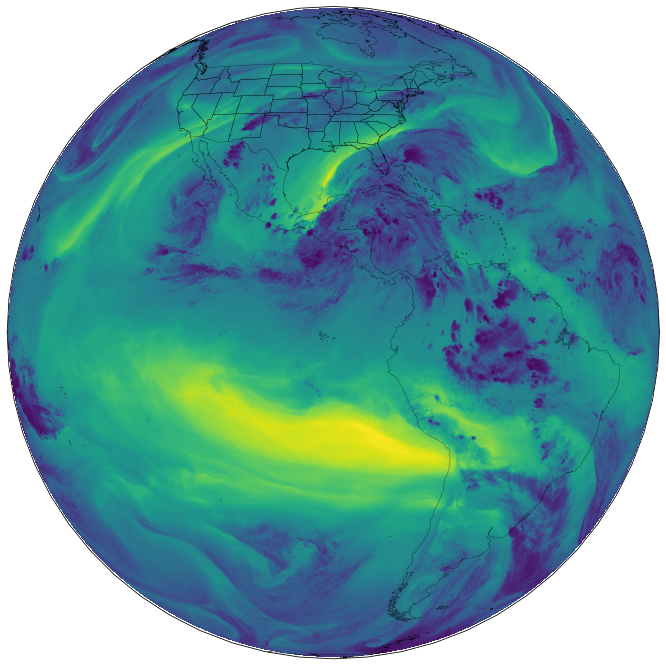

In [18]:
dat = ds.metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs
x = dat.x
y = dat.y
fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = plt.axes(projection=geos)
# plt.title("Hurricane Dorian Path overlayed with GOES-16 Band 09 Water Vapor imagery \n at {}".format(wv_timestamp))
ds_data = ds['Rad'].data
ax.imshow(ds_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos)
# Add Coastlines and States
ax.coastlines(resolution='50m', color='black', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

In [31]:
ds['Rad'].data.shape

(5424, 5424)

In [47]:
pd.date_range("2000-01-01", periods=365, freq='3H')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 03:00:00',
               '2000-01-01 06:00:00', '2000-01-01 09:00:00',
               '2000-01-01 12:00:00', '2000-01-01 15:00:00',
               '2000-01-01 18:00:00', '2000-01-01 21:00:00',
               '2000-01-02 00:00:00', '2000-01-02 03:00:00',
               ...
               '2000-02-14 09:00:00', '2000-02-14 12:00:00',
               '2000-02-14 15:00:00', '2000-02-14 18:00:00',
               '2000-02-14 21:00:00', '2000-02-15 00:00:00',
               '2000-02-15 03:00:00', '2000-02-15 06:00:00',
               '2000-02-15 09:00:00', '2000-02-15 12:00:00'],
              dtype='datetime64[ns]', length=365, freq='3H')